Automating the links scraping process 

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Step 1: Fetch homepage
url = "https://thirdwavenearme.com/"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

# Step 2: Extract city links
city_links = []
table = soup.find("tbody", class_="list")
if table:
    rows = table.find_all("tr")
    for row in rows:
        place_cell = row.find("td", class_="place")
        if place_cell:
            link_tag = place_cell.find("a", href=True)
            if link_tag:
                city_links.append({
                    "city": link_tag.text.strip(),
                    "relative_url": link_tag["href"],
                    "full_url": url.rstrip("/") + link_tag["href"]
                })

# Step 3: Save to CSV
df = pd.DataFrame(city_links)
df.to_csv("third_wave_city_links.csv", index=False)

print("✅ Saved to third_wave_city_links.csv")


Finding the Google map links

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

# Load existing CSV with full_url
df = pd.read_csv("third_wave_city_links.csv")

# Create a list to store map links
map_links = []

# Loop through each city page
for index, row in df.iterrows():
    try:
        print(f"Fetching: {row['full_url']}")
        response = requests.get(row['full_url'], timeout=10)
        soup = BeautifulSoup(response.content, "html.parser")

        # Find the map link
        map_tag = soup.find("a", class_="map-link", href=True)
        if map_tag:
            map_links.append(map_tag['href'])
        else:
            map_links.append(None)

        time.sleep(1)  # Be kind to the server

    except Exception as e:
        print(f"Error on {row['full_url']}: {e}")
        map_links.append(None)

# Add the new column
df["map_link"] = map_links

# Save to updated CSV
df.to_csv("third_wave_city_links_with_map.csv", index=False)

print("✅ All map links added and saved to 'third_wave_city_links_with_map.csv'")


Getting the location files using Playwright but this did not save into real folders, only in inivsible folders that couldnt be transfered after

In [ ]:
# import pandas as pd
# import asyncio
# import nest_asyncio
# from playwright.async_api import async_playwright
# import os

# nest_asyncio.apply()

# # Load CSV
# df = pd.read_csv("third_wave_city_links_with_map.csv")
# rows = df[["city", "map_link"]].dropna().to_dict(orient="records")

# # Use a real user data directory (persistent profile)
# user_data_dir = os.path.expanduser("~/Documents/kml_browser_profile")
# download_dir = os.path.expanduser("~/Documents/kml_downloads")
# os.makedirs(download_dir, exist_ok=True)

# async def open_tabs_and_save_to_real_folder(playwright):
#     context = await playwright.chromium.launch_persistent_context(
#         user_data_dir=user_data_dir,
#         headless=False,
#         accept_downloads=True,
#         downloads_path=download_dir
#     )

#     for row in rows:
#         city = row["city"]
#         link = row["map_link"]

#         try:
#             print(f"🧭 Opening {city}: {link}")
#             page = await context.new_page()
#             await page.goto(link, timeout=60000)

#             # Click the 3-dot menu
#             await page.wait_for_selector("div.mU4ghb-xl07Ob-LgbsSe", timeout=15000)
#             await page.click("div.mU4ghb-xl07Ob-LgbsSe")

#             print(f"✨ Ready for {city}. Manually click 'Download KML', tick box, and OK.")
#             await asyncio.sleep(2)

#         except Exception as e:
#             print(f"❌ Failed for {city}: {e}")

#     print("✅ All tabs opened. Downloads will now go to:", download_dir)

#     # 🛑 Keep browser open for manual actions
#     while True:
#         await asyncio.sleep(3600)

# # Run
# async def main():
#     async with async_playwright() as p:
#         await open_tabs_and_save_to_real_folder(p)

# await main()

Opening them all inside Chrome and manually download

In [ ]:
import pandas as pd
import webbrowser
import time

# Load CSV
df = pd.read_csv("third_wave_city_links_with_map.csv")
map_links = df['map_link'].dropna().tolist()

# Open all map links at once
for url in map_links:
    print(f"🌐 Opening: {url}")
    webbrowser.open(url)
    time.sleep(0.3)  # tiny delay to avoid overwhelming your system

print("\n✅ All tabs opened in your browser.")
print("👉 Please go through each one and manually click 'Download KML' → tick 'Export as KML' → OK.")
print("📂 Files will be saved in your default Downloads folder.")


checking for missing files 

In [ ]:
import pandas as pd
import os
import re

# Load your cities from CSV
df = pd.read_csv("third_wave_city_links_with_map.csv")
cities = df['city'].dropna().tolist()

# Clean city names to compare
def clean_city_name(name):
    return re.sub(r"[^\w\s-]", "", name).strip().replace(" ", "_")

expected_cities = [clean_city_name(city) for city in cities]

# List all downloaded KML files
download_dir = os.path.expanduser("/Users/chivo/Downloads/data_studio/coffee/kml_downloads/")
downloaded_files = os.listdir(download_dir)

# Function to extract clean city name from downloaded filename
def extract_city_from_filename(filename):
    filename = filename.replace("Thirdwavenearme.com ", "")
    filename = re.sub(r"\s*\(\d+\)", "", filename)  # remove (2), (3), etc.
    filename = filename.replace(".kml", "")
    return clean_city_name(filename)

# Build set of extracted city names from files
downloaded_cities = set()
for f in downloaded_files:
    if f.endswith(".kml"):
        city_name = extract_city_from_filename(f)
        downloaded_cities.add(city_name)

# Now compare
missing_cities = []
for city in expected_cities:
    if city not in downloaded_cities:
        missing_cities.append(city)

# Report results
if missing_cities:
    print("\n❌ Missing KMLs for these cities:")
    for city in missing_cities:
        print("-", city)
else:
    print("\n✅ All cities successfully downloaded!")


Rename the files to the city name

In [ ]:
import os
import re

# Folder where your KML files are
download_dir = os.path.expanduser("/Users/chivo/Downloads/data_studio/coffee/kml_downloads/")

# Clean function
def clean_city_name(name):
    return re.sub(r"[^\w\s-]", "", name).strip().replace(" ", "_")

# Go through all .kml files
for filename in os.listdir(download_dir):
    if filename.endswith(".kml"):
        # Step 1: Remove "Thirdwavenearme.com " prefix
        new_name = filename.replace("Thirdwavenearme.com ", "")
        # Step 2: Remove duplicate markers like (2), (3)
        new_name = re.sub(r"\s*\(\d+\)", "", new_name)
        # Step 3: Remove ".kml" for now
        new_name = new_name.replace(".kml", "")
        # Step 4: Clean up name
        new_name = clean_city_name(new_name)
        # Step 5: Add back ".kml"
        new_name = f"{new_name}.kml"

        # Full paths
        old_path = os.path.join(download_dir, filename)
        new_path = os.path.join(download_dir, new_name)

        # Only rename if necessary
        if old_path != new_path:
            print(f"🔄 Renaming {filename} -> {new_name}")
            os.rename(old_path, new_path)

print("\n✅ Done renaming all KML files!")


Okay now, one huge csv file 


In [ ]:
import os
import pandas as pd
import xml.etree.ElementTree as ET

# Folder containing your KML files
download_dir = "/Users/chivo/Downloads/data_studio/coffee/kml_downloads"

# List to collect all data
all_places = []

# Parse each KML file
for filename in os.listdir(download_dir):
    if filename.endswith(".kml"):
        city = filename.replace(".kml", "")
        file_path = os.path.join(download_dir, filename)

        try:
            tree = ET.parse(file_path)
            root = tree.getroot()

            # Define namespace
            ns = {'kml': 'http://www.opengis.net/kml/2.2'}

            # Find all Placemarks
            for placemark in root.findall(".//kml:Placemark", ns):
                name_elem = placemark.find("kml:name", ns)
                coords_elem = placemark.find(".//kml:coordinates", ns)

                if name_elem is not None and coords_elem is not None:
                    place_name = name_elem.text.strip()
                    coords_text = coords_elem.text.strip()
                    longitude, latitude, *_ = coords_text.split(",")

                    all_places.append({
                        "city": city,
                        "place_name": place_name,
                        "latitude": float(latitude),
                        "longitude": float(longitude)
                    })

        except Exception as e:
            print(f"❌ Failed parsing {filename}: {e}")

# Turn into DataFrame
df_places = pd.DataFrame(all_places)

# Save to CSV
output_csv = "/Users/chivo/Downloads/data_studio/coffee/all_thirdwave_places.csv"
df_places.to_csv(output_csv, index=False)

print(f"\n✅ Saved all parsed places to: {output_csv}")


finding coffee shops name links

In [ ]:
import pandas as pd
import asyncio
from playwright.async_api import async_playwright
import os

# Load coffee shop CSV
df = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/all_thirdwave_places.csv")
shops = df[['city', 'place_name']].drop_duplicates().to_dict(orient='records')

# Storage for results
results = []

async def get_bing_results():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=False)
        context = await browser.new_context()
        page = await context.new_page()

        for i, shop in enumerate(shops):
            city = shop['city']
            name = shop['place_name']
            query = f"{name} {city} coffee site:.com OR site:.co OR site:.net"

            try:
                print(f"🔍 Searching on Bing: {query}")
                await page.goto(f"https://www.bing.com/search?q={query.replace(' ', '+')}", timeout=60000)

                # Wait for results to load
                await page.wait_for_selector('li.b_algo h2 a', timeout=10000)

                # Grab the first non-ad link
                link = await page.query_selector('li.b_algo h2 a')
                href = await link.get_attribute('href') if link else None

                if href:
                    print(f"✅ Found: {href}")
                    results.append({'city': city, 'shop_name': name, 'website_url': href})
                else:
                    results.append({'city': city, 'shop_name': name, 'website_url': None})
                    print(f"⚠️ No link found.")

                await asyncio.sleep(2)  # Slow down to avoid suspicion

            except Exception as e:
                print(f"❌ Failed for {name} in {city}: {e}")
                results.append({'city': city, 'shop_name': name, 'website_url': None})

        await browser.close()

    # Save results
    out_path = "/Users/chivo/Downloads/data_studio/coffee/coffee_shop_websites.csv"
    pd.DataFrame(results).to_csv(out_path, index=False)
    print(f"\n✅ Saved website results to: {out_path}")

# Run it
await get_bing_results()


more than half of the links are generic webpages

In [ ]:
import pandas as pd

# Load your data
df = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/full_cleaned_with_flags.csv")

# Extract domain
df['domain'] = df['website_url'].dropna().apply(lambda x: x.split('/')[2] if '://' in x else '')

# Known platforms to exclude
platform_domains = [
    "yelp.com", "instagram.com", "facebook.com", "tripadvisor.com", "foodandwine.com",
    "timeout.com", "roastycoffee.com", "homegrounds.co", "zomato.com", "openrice.com",
    "cntraveler.com", "trueid.net", "msn.com", "axios.com", "starterskitchen.com", "google.com",
    "youtube.com", "pinterest.com", "reddit.com", "theculturetrip.com"
]

# Filter 1: Valid TLD
df['tld_valid'] = df['domain'].apply(lambda d: isinstance(d, str) and any(d.endswith(tld) for tld in ['.com', '.co', '.net']))

# Filter 2: Not a known platform
df['not_platform'] = df['domain'].apply(lambda d: isinstance(d, str) and d not in platform_domains)

# Filter 3: Shop name (loosely) appears in domain
def loose_match(row):
    if not isinstance(row['domain'], str) or not isinstance(row['shop_name'], str):
        return False
    shop_parts = [p for p in row['shop_name'].lower().split() if len(p) > 2]
    return any(p in row['domain'].lower() for p in shop_parts)

df['shop_in_domain'] = df.apply(loose_match, axis=1)

# Final filter
filtered = df[df['tld_valid'] & df['not_platform'] & df['shop_in_domain']].copy()

# Save
out_path = "/Users/chivo/Downloads/data_studio/coffee/high_confidence_loosematch.csv"
filtered[['city', 'shop_name', 'website_url']].drop_duplicates().to_csv(out_path, index=False)

print(f"\n✅ Saved {len(filtered)} expanded high-confidence matches to:\n{out_path}")


In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/full_cleaned_with_flags.csv")

# Extract domain safely
df['domain'] = df['website_url'].dropna().apply(lambda x: x.split('/')[2] if '://' in x else '')

# Expanded list of known non-café platforms and media sites
platform_domains = [
    "yelp.com", "www.yelp.com", "instagram.com", "www.instagram.com",
    "facebook.com", "www.facebook.com", "tripadvisor.com", "www.tripadvisor.com",
    "foodandwine.com", "timeout.com", "roastycoffee.com", "homegrounds.co",
    "thatch.co", "openrice.com", "zomato.com", "theculturetrip.com", "cntraveler.com",
    "trueid.net", "msn.com", "axios.com", "starterskitchen.com", "google.com",
    "youtube.com", "pinterest.com", "reddit.com"
]

# Step 1: Keep only if TLD is good
df['tld_valid'] = df['domain'].apply(lambda d: isinstance(d, str) and any(d.endswith(tld) for tld in ['.com', '.co', '.net']))

# Step 2: Exclude known platform domains
df['not_platform'] = df['domain'].apply(lambda d: d not in platform_domains if isinstance(d, str) else False)

# Step 3: Final filter
filtered = df[df['tld_valid'] & df['not_platform']].copy()

# Save it
out_path = "/Users/chivo/Downloads/data_studio/coffee/high_confidence_expanded.csv"
filtered[['city', 'shop_name', 'website_url']].drop_duplicates().to_csv(out_path, index=False)

print(f"\n✅ Saved {len(filtered)} expanded high-confidence café sites to:\n{out_path}")


filtered shop links that arent real and extract text from homepage 


In [ ]:
import pandas as pd
import asyncio
import nest_asyncio
from playwright.async_api import async_playwright
import os
import re

nest_asyncio.apply()

# Paths
input_csv = "/Users/chivo/Downloads/data_studio/coffee/high_confidence_real_shops.csv"
new_output = "/Users/chivo/Downloads/data_studio/coffee/scraped_text_fresh.csv"

# Load full site list
df = pd.read_csv(input_csv)
shops = df[['city', 'shop_name', 'website_url']].dropna().drop_duplicates().to_dict(orient='records')

# Clean names for filenames
def clean(name):
    return re.sub(r"[^\w\s-]", "", name).strip().replace(" ", "_")

# Prepare for results
results = []

async def scrape_text():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        context = await browser.new_context()
        page = await context.new_page()

        for shop in shops:
            city = shop['city']
            name = shop['shop_name']
            url = shop['website_url']

            try:
                print(f"📝 Scraping: {city} — {name} — {url}")
                await page.goto(url, timeout=60000)

                # Wait for the network to settle (JS fully loaded)
                await page.wait_for_load_state("networkidle", timeout=20000)
                await page.wait_for_timeout(5000)  # extra buffer

                # Grab visible text content
                content = await page.eval_on_selector_all(
                    "p, h1, h2, h3, h4, li",
                    "els => els.map(e => e.innerText).join('\\n')"
                )

                results.append({
                    "city": city,
                    "shop_name": name,
                    "website_url": url,
                    "visible_text": content.strip()[:5000] if content else "[NO TEXT FOUND]"
                })

            except Exception as e:
                print(f"❌ Failed for {name}: {e}")
                results.append({
                    "city": city,
                    "shop_name": name,
                    "website_url": url,
                    "visible_text": "[ERROR]"
                })

        await browser.close()

# Run scrape
await scrape_text()

# Save fresh output
pd.DataFrame(results).to_csv(new_output, index=False)
print(f"\n✅ Fresh scrape complete. New file saved to:\n{new_output}")


TF-IDF (Term Frequency–Inverse Document Frequency) to identify the most distinctive words for each city.  highlights words that are common in a city's café language but rare elsewhere,

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load your CSV (replace with your actual path)
df = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/scraped_text_expanded.csv")

# Filter out rows with no usable text
valid_df = df[df['visible_text'].notna() & ~df['visible_text'].isin(['[NO TEXT FOUND]', '[ERROR]'])]

# Group all shop text per city into one large string
city_texts = valid_df.groupby('city')['visible_text'].apply(lambda texts: ' '.join(texts)).reset_index()

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(city_texts['visible_text'])

# Get word list
words = vectorizer.get_feature_names_out()

# Convert matrix to DataFrame
tfidf_df = pd.DataFrame(X.toarray(), index=city_texts['city'], columns=words)

# For each city, get top 5 words
top_words_per_city = {}
for city in tfidf_df.index:
    top_words = tfidf_df.loc[city].sort_values(ascending=False).head(5).index.tolist()
    top_words_per_city[city] = top_words

# Convert to DataFrame
top_words_df = pd.DataFrame.from_dict(top_words_per_city, orient='index', columns=[f"top_word_{i+1}" for i in range(5)])

# Save results
out_path = "/Users/chivo/Downloads/data_studio/coffee/tfidf_homepage_top_words_by_city.csv"
top_words_df.to_csv(out_path)

print(f"\n✅ TF-IDF analysis complete! Top words saved to:\n{out_path}")


Filter coffee shop links that are reliable to check menu manually 

In [ ]:
import pandas as pd

# Load the high-confidence shops
df = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/high_confidence_real_shops.csv")

# Drop missing or duplicate URLs
df = df.dropna(subset=["website_url"]).drop_duplicates(subset=["website_url"])

# Add a simple metric for "URL depth" (lower = homepage-level)
df['url_depth'] = df['website_url'].apply(lambda x: x.count('/'))

# Keep only shallow URLs (homepages or simple menu pages)
filtered = df[df['url_depth'] <= 3].copy()

# Group by city and select up to 3 cafes per city
sampled = (
    filtered.groupby('city')
    .apply(lambda group: group.sample(min(len(group), 3), random_state=42))
    .reset_index(drop=True)
)

# Save output
out_path = "/Users/chivo/Downloads/data_studio/coffee/curated_cafes_per_city.csv"
sampled[['city', 'shop_name', 'website_url']].to_csv(out_path, index=False)

print(f"✅ Saved 2–3 cafés per city to:\n{out_path}")


Screenshots of coffee shops' front pages to see UI differences 

In [ ]:
import pandas as pd
import os
import re
import asyncio
from playwright.async_api import async_playwright
import nest_asyncio

nest_asyncio.apply()

# Load your curated CSV
df = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/curated_cafes_per_city.csv")
shops = df[['city', 'shop_name', 'website_url']].dropna().drop_duplicates().to_dict(orient='records')

# Folder to save screenshots
base_dir = "/Users/chivo/Downloads/data_studio/coffee/screenshots"

# Clean names for folders/files
def clean(name):
    return re.sub(r"[^\w\s-]", "", name).strip().replace(" ", "_")

# Main function
async def capture_screenshots():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        context = await browser.new_context(viewport={"width": 1280, "height": 800})

        for shop in shops:
            city = clean(shop['city'])
            name = clean(shop['shop_name'])
            url = shop['website_url']
            print(f"📸 Capturing: {city} - {name}")

            save_path = os.path.join(base_dir, city)
            os.makedirs(save_path, exist_ok=True)

            try:
                page = await context.new_page()
                await page.goto(url, timeout=60000)
                await page.wait_for_timeout(10000)  # ⏳ Wait 10s for full load

                # Screenshot 1: Top
                await page.screenshot(path=os.path.join(save_path, f"{name}_top.png"))

                # Scroll mid
                await page.evaluate("window.scrollTo(0, document.body.scrollHeight / 2)")
                await page.wait_for_timeout(1000)
                await page.screenshot(path=os.path.join(save_path, f"{name}_mid.png"))

                # Scroll bottom
                await page.evaluate("window.scrollTo(0, document.body.scrollHeight)")
                await page.wait_for_timeout(1000)
                await page.screenshot(path=os.path.join(save_path, f"{name}_bottom.png"))

                await page.close()

            except Exception as e:
                print(f"❌ Failed for {name}: {e}")

        await browser.close()

# Run it
await capture_screenshots()


In [ ]:
import pandas as pd
import os
import re
import asyncio
from playwright.async_api import async_playwright
import nest_asyncio

nest_asyncio.apply()

# 🔁 Load the expanded full list instead
df = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/high_confidence_real_shops.csv")
shops = df[['city', 'shop_name', 'website_url']].dropna().drop_duplicates().to_dict(orient='records')

# Folder to save screenshots
base_dir = "/Users/chivo/Downloads/data_studio/coffee/screenshots"

# Clean city/shop names for folders and filenames
def clean(name):
    return re.sub(r"[^\w\s-]", "", name).strip().replace(" ", "_")

# Check if all 3 screenshots already exist
def screenshots_exist(city, name):
    city_folder = os.path.join(base_dir, city)
    return all(os.path.exists(os.path.join(city_folder, f"{name}_{pos}.png")) for pos in ["top", "mid", "bottom"])

# Main screenshot function
async def capture_screenshots():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        context = await browser.new_context(viewport={"width": 1280, "height": 800})

        for shop in shops:
            city = clean(shop['city'])
            name = clean(shop['shop_name'])
            url = shop['website_url']

            if screenshots_exist(city, name):
                print(f"✅ Skipping (already exists): {city} – {name}")
                continue

            print(f"📸 Capturing: {city} – {name}")
            save_path = os.path.join(base_dir, city)
            os.makedirs(save_path, exist_ok=True)

            try:
                page = await context.new_page()
                await page.goto(url, timeout=60000)
                await page.wait_for_timeout(3000)

                # Screenshot top
                await page.screenshot(path=os.path.join(save_path, f"{name}_top.png"))

                # Scroll mid
                await page.evaluate("window.scrollTo(0, document.body.scrollHeight / 2)")
                await page.wait_for_timeout(1000)
                await page.screenshot(path=os.path.join(save_path, f"{name}_mid.png"))

                # Scroll bottom
                await page.evaluate("window.scrollTo(0, document.body.scrollHeight)")
                await page.wait_for_timeout(1000)
                await page.screenshot(path=os.path.join(save_path, f"{name}_bottom.png"))

                await page.close()

            except Exception as e:
                print(f"❌ Failed for {name}: {e}")

        await browser.close()

# Run
await capture_screenshots()


Translating homepage content to english (google translate vs openai)

In [ ]:
!pip install openai
!pip install langdetect


In [15]:
import openai
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Set API key
openai.api_key = os.getenv("OPENAI_API_KEY")


OpenAI translation

In [ ]:
import pandas as pd
from langdetect import detect
import openai

# Load your scraped file
df = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/scraped_coffee_text.csv")
df = df[df['visible_text'].notna() & ~df['visible_text'].isin(['[NO TEXT FOUND]', '[ERROR]'])].copy()

# Step 1: Detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

df['detected_lang'] = df['visible_text'].apply(detect_language)

# Step 2: Translate non-English text using GPT
def gpt_translate(text):
    prompt = (
        "Translate the following café homepage text into English. "
        "Preserve the tone, poetic style, or marketing feel:\n\n"
        f"{text}\n\nEnglish:"
    )
    try:
        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7,
        )
        return response.choices[0].message['content'].strip()
    except Exception as e:
        return "[GPT ERROR]"

# Step 3: Only translate if language ≠ English
df['translated_text'] = df.apply(
    lambda row: gpt_translate(row['visible_text']) if row['detected_lang'] != 'en' else row['visible_text'],
    axis=1
)

# Save result
output_path = "/Users/chivo/Downloads/data_studio/coffee/translated_text_with_lang_detect.csv"
df.to_csv(output_path, index=False)
print(f"\n✅ Translation complete. Saved to:\n{output_path}")


google translate 

In [ ]:
!pip install googletrans==4.0.0-rc1


In [ ]:
import pandas as pd
from googletrans import Translator

# Load your scraped dataset
df = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/scraped_coffee_text.csv")

# Filter for valid text
valid_df = df[df['visible_text'].notna() & ~df['visible_text'].isin(['[NO TEXT FOUND]', '[ERROR]'])].copy()

# Init translator
translator = Translator()

# Translate and detect language
translated_texts = []
detected_langs = []

for text in valid_df['visible_text']:
    try:
        result = translator.translate(text, dest='en')
        translated_texts.append(result.text)
        detected_langs.append(result.src)
    except Exception as e:
        translated_texts.append("[TRANSLATION ERROR]")
        detected_langs.append("unknown")

# Add results to DataFrame
valid_df['original_language'] = detected_langs
valid_df['translated_text'] = translated_texts

# Save
output_path = "/Users/chivo/Downloads/data_studio/coffee/translated_text_google.csv"
valid_df.to_csv(output_path, index=False)

print(f"\n✅ Translations saved to:\n{output_path}")


Finding instagram pages: results: this has failed miserably. 

In [ ]:
# import pandas as pd
# import requests
# from bs4 import BeautifulSoup
# from playwright.async_api import async_playwright
# import asyncio
# import random
# import os
# from pathlib import Path
# import nest_asyncio

# nest_asyncio.apply()

# # === CONFIG ===
# BATCH_NUM = 1
# INPUT_CSV = f"/Users/chivo/Downloads/data_studio/coffee/instagram_batch_{BATCH_NUM}.csv"
# OUTPUT_CSV = f"/Users/chivo/Downloads/data_studio/coffee/instagram_scraped_batch_{BATCH_NUM}.csv"
# SCREENSHOT_DIR = f"/Users/chivo/Downloads/data_studio/coffee/ig_screenshots"
# MAX_CAPTIONS = 20

# os.makedirs(SCREENSHOT_DIR, exist_ok=True)

# # === STEP 1: Improved Bing Search Function ===
# def search_instagram_url(place_name, city):
#     query = f"{place_name} {city} instagram"
#     headers = {"User-Agent": "Mozilla/5.0"}
#     url = f"https://www.bing.com/search?q={query.replace(' ', '+')}"
#     try:
#         response = requests.get(url, headers=headers, timeout=10)
#         soup = BeautifulSoup(response.text, "html.parser")
#         for a in soup.find_all("a", href=True):
#             href = a["href"]
#             if href.startswith("https://www.instagram.com/") and "accounts" not in href:
#                 return href.split("?")[0]
#     except Exception as e:
#         print(f"❌ Bing search error for '{query}': {e}")
#     return None

# # === STEP 2: Scrape IG Bio + Captions + Screenshot ===
# async def scrape_instagram_info(url, page, screenshot_path):
#     try:
#         await page.goto(url, timeout=60000)
#         await page.wait_for_timeout(7000)

#         # Dismiss login modal
#         try:
#             modal = page.locator("div[role='dialog'] button:has-text('Not Now')")
#             if await modal.is_visible():
#                 await modal.click()
#                 await page.wait_for_timeout(1000)
#         except:
#             pass

#         # Scroll and screenshot
#         await page.keyboard.press("PageDown")
#         await page.wait_for_timeout(2000)
#         await page.screenshot(path=screenshot_path, full_page=True)

#         # Bio text
#         bio_elems = page.locator("header section > div > h1, header section > div > span")
#         bio_texts = await bio_elems.all_inner_texts()
#         bio = " ".join(bio_texts).strip()

#         # Captions
#         captions = await page.locator("ul li div[role='button'] span").all_inner_texts()
#         return bio, [c.strip() for c in captions if c.strip()][:MAX_CAPTIONS]

#     except Exception as e:
#         print(f"❌ Instagram scrape failed: {e}")
#         return "[ERROR]", []

# # === STEP 3: Run Everything ===
# async def run_batch():
#     df = pd.read_csv(INPUT_CSV)
#     df["instagram_url"] = ""
#     df["instagram_bio"] = ""
#     df["captions"] = ""
#     df["screenshot_path"] = ""

#     async with async_playwright() as p:
#         browser = await p.chromium.launch(headless=True)
#         context = await browser.new_context()

#         for i, row in df.iterrows():
#             name = row['place_name']
#             city = row['city']
#             clean_name = "_".join(str(name).strip().split())[:40]
#             clean_city = "_".join(str(city).strip().split())[:40]

#             print(f"{i+1}/{len(df)} 🔍 {name} — {city}")
#             ig_url = search_instagram_url(name, city)
#             df.at[i, "instagram_url"] = ig_url if ig_url else "[NOT FOUND]"

#             if ig_url and ig_url.startswith("https://www.instagram.com/"):
#                 try:
#                     page = await context.new_page()
#                     screenshot_path = os.path.join(SCREENSHOT_DIR, f"{clean_name}_{clean_city}.png")
#                     bio, captions = await scrape_instagram_info(ig_url, page, screenshot_path)
#                     df.at[i, "instagram_bio"] = bio
#                     df.at[i, "captions"] = "\n".join(captions)
#                     df.at[i, "screenshot_path"] = screenshot_path
#                     await page.close()
#                 except Exception as e:
#                     print(f"❌ Failed for {ig_url}: {e}")
#             else:
#                 df.at[i, "instagram_bio"] = "[NOT FOUND]"
#                 df.at[i, "captions"] = ""
#                 df.at[i, "screenshot_path"] = ""

#             await asyncio.sleep(random.uniform(3, 6))

#         await browser.close()

#     df.to_csv(OUTPUT_CSV, index=False)
#     print(f"\n✅ Batch {BATCH_NUM} complete. Saved to:\n{OUTPUT_CSV}")

# # === LAUNCH ===
# await run_batch()


Collating screenshots of the homepage of cafes with found URL

In [ ]:
import os
import csv

# Define the base directory containing the screenshots
base_dir = '/Users/chivo/Downloads/data_studio/coffee/screenshots'

# List to store the data rows
data = []

# Traverse the directory structure
for city in os.listdir(base_dir):
    city_path = os.path.join(base_dir, city)
    if os.path.isdir(city_path):
        for filename in os.listdir(city_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Extract coffee shop name by removing the file extension
                coffee_shop_name = os.path.splitext(filename)[0]
                # Construct the full path to the screenshot
                screenshot_path = os.path.join(city_path, filename)
                # Append the data row
                data.append([city, coffee_shop_name, screenshot_path])

# Define the output CSV file path
output_csv = '/Users/chivo/Downloads/coffee_shops.csv'

# Write the data to the CSV file
with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    # Write the header
    writer.writerow(['city', 'coffee_shop_name', 'screenshot_path'])
    # Write the data rows
    writer.writerows(data)

print(f"CSV file created at: {output_csv}")


attempt at automating the process of collating screenshots of the homepage of cafes with found URL, ... again ... 

In [4]:
import pandas as pd
import time
import random
from bs4 import BeautifulSoup
from langdetect import detect, DetectorFactory
from pathlib import Path
from playwright.async_api import async_playwright
import nest_asyncio
import asyncio

# Patch asyncio for Jupyter
nest_asyncio.apply()
DetectorFactory.seed = 0

# Paths
BASE_DIR = Path("/Users/chivo/Downloads/data_studio/coffee/")
main_file = BASE_DIR / "high_confidence_real_shops.csv"  # ✅ now using verified list only
output_file = BASE_DIR / "coffee_shops_scraped_output.csv"
fail_log = BASE_DIR / "failed_scrapes.csv"

# Load only the verified file and prepare scrape columns
main_df = pd.read_csv(main_file)

# Add any columns needed for scraping output
required_columns = [
    "bio_text", "taglines_or_headers", "menu_items", "language", "visible_text_all",
    "screenshot_top", "screenshot_middle", "screenshot_bottom",
    "instagram_url_scraped", "facebook_url_scraped", "tiktok_url_scraped",
    "bio_text_confidence", "taglines_or_headers_confidence",
    "menu_items_confidence", "language_confidence", "confirmed_real_page"
]

for col in required_columns:
    if col not in main_df.columns:
        main_df[col] = ""

# Mark all as confirmed real pages
main_df["confirmed_real_page"] = True

# Track failures
failed_urls = []

# Helper: make safe file names
def safe_name(name):
    return name.strip().replace(" ", "_").replace("/", "_")

# Scraper function
# Scraper function (updated)
async def scrape_page(url, page, city, shop_name, base_dir, retries=2):
    for attempt in range(retries):
        try:
            print(f"⏳ Loading {url} (attempt {attempt+1})...")

            try:
                await page.goto(url, timeout=45000, wait_until='domcontentloaded')
                await page.evaluate("window.scrollTo(0, document.body.scrollHeight)")
                await page.wait_for_timeout(5000)  # Allow dynamic content to load
            except Exception as load_error:
                print(f"⛔️ Could not load {url}: {load_error}")
                return "", "", "", "", "", "", "", "", "", "", ""

            # Screenshot paths
            screenshot_dir = base_dir / "screenshots_attempt2" / safe_name(city)
            screenshot_dir.mkdir(parents=True, exist_ok=True)

            top_path = screenshot_dir / f"{safe_name(shop_name)}_top.png"
            await page.screenshot(path=str(top_path), full_page=False)

            await page.evaluate("window.scrollTo(0, document.body.scrollHeight / 2)")
            await page.wait_for_timeout(1000)
            middle_path = screenshot_dir / f"{safe_name(shop_name)}_middle.png"
            await page.screenshot(path=str(middle_path), full_page=False)

            await page.evaluate("window.scrollTo(0, document.body.scrollHeight)")
            await page.wait_for_timeout(1000)
            bottom_path = screenshot_dir / f"{safe_name(shop_name)}_bottom.png"
            await page.screenshot(path=str(bottom_path), full_page=False)

            # Scrape visible text
            content = await page.content()
            soup = BeautifulSoup(content, "html.parser")
            full_text = soup.get_text(separator=' ', strip=True)

            heading = soup.find(["h1", "h2", "h3"])
            heading_text = heading.get_text(strip=True) if heading else ""

            meta = soup.find("meta", attrs={"name": "description"})
            bio_text = meta["content"] if meta and "content" in meta.attrs else full_text[:300]

            menu_snippet = ""
            if "menu" in full_text.lower():
                menu_items = soup.find_all("li")
                menu_snippet = " | ".join([t.get_text(strip=True) for t in menu_items][:5])

            lang = detect(full_text[:400]) if len(full_text) > 50 else ""

            # Social media links
            instagram_url = ""
            facebook_url = ""
            tiktok_url = ""
            for a in soup.find_all("a", href=True):
                href = a["href"]
                if "instagram.com" in href and not instagram_url:
                    instagram_url = href
                elif "facebook.com" in href and not facebook_url:
                    facebook_url = href
                elif "tiktok.com" in href and not tiktok_url:
                    tiktok_url = href

            return (
                bio_text, heading_text, menu_snippet, lang, full_text,
                str(top_path), str(middle_path), str(bottom_path),
                instagram_url, facebook_url, tiktok_url
            )

        except Exception as e:
            print(f"⚠️ Attempt {attempt+1} failed during scraping phase on {url}: {e}")
            if attempt == retries - 1:
                return "", "", "", "", "", "", "", "", "", "", ""
            await page.wait_for_timeout(3000)


# Main scrape runner
async def run_scrape(limit=None):  # Set limit=None to run all
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        counter = 0
        for i, row in main_df.iterrows():
            if pd.notna(row["website_url"]) and row["confirmed_real_page"]:
                print(f"\n☕ Scraping {row['shop_name']} ({row['city']})...")
                (
                    bio, heading, menu, lang, full_text,
                    path_top, path_middle, path_bottom,
                    insta_url, fb_url, tiktok_url
                ) = await scrape_page(row["website_url"], page, row["city"], row["shop_name"], BASE_DIR)

                # Save values
                main_df.at[i, "bio_text"] = bio
                main_df.at[i, "taglines_or_headers"] = heading
                main_df.at[i, "menu_items"] = menu
                main_df.at[i, "language"] = lang
                main_df.at[i, "visible_text_all"] = full_text

                main_df.at[i, "screenshot_top"] = path_top
                main_df.at[i, "screenshot_middle"] = path_middle
                main_df.at[i, "screenshot_bottom"] = path_bottom

                main_df.at[i, "instagram_url_scraped"] = insta_url
                main_df.at[i, "facebook_url_scraped"] = fb_url
                main_df.at[i, "tiktok_url_scraped"] = tiktok_url

                main_df.at[i, "bio_text_confidence"] = len(bio) > 30
                main_df.at[i, "taglines_or_headers_confidence"] = len(heading) > 10
                main_df.at[i, "menu_items_confidence"] = len(menu) > 10
                main_df.at[i, "language_confidence"] = lang != ""

                if all(v == "" for v in [bio, heading, menu, lang]):
                    failed_urls.append({
                        "city": row["city"],
                        "shop_name": row["shop_name"],
                        "website_url": row["website_url"]
                    })

                counter += 1
                await page.wait_for_timeout(random.randint(2000, 5000))

                if limit and counter >= limit:
                    break

        await browser.close()
        main_df.to_csv(output_file, index=False)
        print(f"\n✅ Done! Saved {counter} entries to: {output_file}")

        if failed_urls:
            pd.DataFrame(failed_urls).to_csv(fail_log, index=False)
            print(f"⚠️ Logged {len(failed_urls)} failed URLs to: {fail_log}")


In [6]:
await run_scrape(limit=1)  # Start with 5, then increase



✅ Done! Saved 1 entries to: /Users/chivo/Downloads/data_studio/coffee/coffee_shops_scraped_output.csv


In [7]:
await run_scrape(limit=None) 



☕ Scraping https://columbus.bg/ (https://columbus.bg/)...
⏳ Loading https://columbus.bg/ (attempt 1)...

☕ Scraping Sip | Stir Cafe (Dallas)...
⏳ Loading https://sipstircoffeehouse.com/ (attempt 1)...

☕ Scraping Cultivar Coffee Bar & Roaster (Dallas) (Dallas)...
⏳ Loading https://www.cultivarcoffee.com/ (attempt 1)...

☕ Scraping Cultivar Coffee Bar & Roaster (Denton) (Dallas)...
⏳ Loading https://www.cultivarcoffee.com/ (attempt 1)...

☕ Scraping Cultivar Coffee Bar & Roaster (Oak Cliff) (Dallas)...
⏳ Loading https://www.cultivarcoffee.com/ (attempt 1)...

☕ Scraping Hoi An Roastery (original shop) (Hoi_An)...
⏳ Loading https://hoianroastery.com/ (attempt 1)...

☕ Scraping Coffee Sapiens (Roastery & Brew Bar) (Istanbul)...
⏳ Loading https://www.coffeesapiens.com/pages/coffee-roasting (attempt 1)...

☕ Scraping Coffee Sapiens (Roastery & Workshop) (Istanbul)...
⏳ Loading https://www.coffeesapiens.com/pages/coffee-roasting (attempt 1)...

☕ Scraping Geyik Coffee Roastery & Cocktail Ba

scrape instagram pages 

In [13]:
!pip install playwright browser-cookie3 pandas
!playwright install



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


This is taking 

In [7]:
import pandas as pd
import os
import re
import asyncio
from playwright.async_api import async_playwright
from http.cookiejar import MozillaCookieJar

# === CONFIG ===
INPUT_CSV = "/Users/chivo/Downloads/data_studio/coffee/instagram_links_fixed.csv"
COOKIES_PATH = "/Users/chivo/Downloads/data_studio/coffee/instagram_cookies.txt"
SCREENSHOT_DIR = "/Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe"
os.makedirs(SCREENSHOT_DIR, exist_ok=True)

# Load cafes with IG links
df = pd.read_csv(INPUT_CSV)
df = df[df["instagram_url"].notna() & df["instagram_url"].str.startswith("http")]

# Clean for filename
def clean(name):
    return re.sub(r"[^\w\s-]", "", str(name)).strip().replace(" ", "_")[:40]

# Read cookies.txt into dict format
def load_cookies_txt(path):
    jar = MozillaCookieJar()
    jar.load(path, ignore_discard=True, ignore_expires=True)
    cookies = []
    for c in jar:
        cookies.append({
            "name": c.name,
            "value": c.value,
            "domain": c.domain,
            "path": c.path,
            "httpOnly": c._rest.get("HttpOnly") is not None,
            "secure": c.secure,
            "sameSite": "Lax"
        })
    return cookies

# Main Playwright function
async def screenshot_instagrams():
    cookies = load_cookies_txt(COOKIES_PATH)

    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=False)
        context = await browser.new_context()
        await context.add_cookies(cookies)
        page = await context.new_page()

        for i, row in df.iterrows():
            name = clean(row["cafe_name"])
            city = clean(row["city"])
            url = row["instagram_url"]
            filename = f"{name}_{city}.png"
            save_path = os.path.join(SCREENSHOT_DIR, filename)

            print(f"{i+1}/{len(df)} 📸 Visiting {name} — {city}")
            try:
                await page.goto(url, timeout=60000)
                await page.wait_for_timeout(8000)
                await page.screenshot(path=save_path, full_page=True)
                print(f"✅ Saved to: {save_path}")
            except Exception as e:
                print(f"❌ Failed: {e}")

        await browser.close()

# Launch it
import nest_asyncio
nest_asyncio.apply()
await screenshot_instagrams()


1/5214 📸 Visiting Фабрика_ДЪГА__Rainbow_Factory — Sofia
✅ Saved to: /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Фабрика_ДЪГА__Rainbow_Factory_Sofia.png
2/5214 📸 Visiting 2_Giraffes — Sofia
✅ Saved to: /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/2_Giraffes_Sofia.png
3/5214 📸 Visiting Chuckys_Coffee_House — Sofia
✅ Saved to: /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Chuckys_Coffee_House_Sofia.png
4/5214 📸 Visiting Percolate_Coffee — Sofia
✅ Saved to: /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Percolate_Coffee_Sofia.png
5/5214 📸 Visiting Drekka — Sofia
✅ Saved to: /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Drekka_Sofia.png
6/5214 📸 Visiting Chuckys_Coffee_Store — Sofia
✅ Saved to: /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Chuckys_Coffee_Store_Sofia.png
7/5214 📸 Visiting Фабрика_ДЪГА_2__Rainbow_Factory_2 — Sofia
✅ Saved to: /Users/chivo/Downloads/data_studio/coffee/ig_screensho

Future exception was never retrieved
future: <Future finished exception=TargetClosedError('Target page, context or browser has been closed')>
playwright._impl._errors.TargetClosedError: Target page, context or browser has been closed


✅ Saved to: /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Toma_Café_Madrid.png
615/5214 📸 Visiting Café_Federal — Madrid
✅ Saved to: /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Café_Federal_Madrid.png
616/5214 📸 Visiting Art_Museum_of_Rochester_-_AMoR — Rochester
✅ Saved to: /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Art_Museum_of_Rochester_-_AMoR_Rochester.png
617/5214 📸 Visiting The_Daily_Grind_Coffeeshop — Rochester
✅ Saved to: /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/The_Daily_Grind_Coffeeshop_Rochester.png
618/5214 📸 Visiting Press_Coffee_Roaster — Rochester
✅ Saved to: /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Press_Coffee_Roaster_Rochester.png
619/5214 📸 Visiting Glen_Edith_Coffee_Bar_Elton_St — Rochester
✅ Saved to: /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Glen_Edith_Coffee_Bar_Elton_St_Rochester.png
620/5214 📸 Visiting Canaltown_Coffee_Roasters — Rochester
✅ Saved

Attempt tp Instagram bio text scraping but it's not working very well 

In [9]:
import pandas as pd
import asyncio
import nest_asyncio
from playwright.async_api import async_playwright
from http.cookiejar import MozillaCookieJar
from rapidfuzz import fuzz
import re
import random
import time
import os

nest_asyncio.apply()

# === CONFIG ===
INPUT_CSV = "/Users/chivo/Downloads/data_studio/coffee/instagram_links_fixed.csv"
COOKIES_PATH = "/Users/chivo/Downloads/data_studio/coffee/instagram_cookies.txt"
OUTPUT_CSV = "/Users/chivo/Downloads/data_studio/coffee/instagram_match_results.csv"
TEMP_CSV = "/Users/chivo/Downloads/data_studio/coffee/temp_instagram_scrape.csv"
PAUSE_BETWEEN = (3, 7)
SAVE_EVERY = 25

# === Load cookies.txt ===
def load_cookies_txt(path):
    jar = MozillaCookieJar()
    jar.load(path, ignore_discard=True, ignore_expires=True)
    cookies = []
    for c in jar:
        cookies.append({
            "name": c.name,
            "value": c.value,
            "domain": c.domain,
            "path": c.path,
            "expires": -1,
            "httpOnly": c._rest.get("HttpOnly", False),
            "secure": c.secure,
            "sameSite": "Lax"
        })
    return cookies

# === Match function ===
def match_score(cafe_name, display_name, bio):
    text = f"{display_name or ''} {bio or ''}".strip()
    score = fuzz.token_set_ratio(cafe_name.lower(), text.lower())
    if score > 80:
        status = "Match"
    elif score > 60:
        status = "Uncertain"
    else:
        status = "No Match"
    return score, status

# === Main scraping loop ===
async def scrape_instagram_profiles(df, existing):
    cookies = load_cookies_txt(COOKIES_PATH)
    results = existing.to_dict("records") if existing is not None else []

    scraped_urls = set(existing["instagram_url"]) if existing is not None else set()

    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=False)
        context = await browser.new_context()
        await context.add_cookies(cookies)
        page = await context.new_page()

        for i, row in df.iterrows():
            cafe_name = row["cafe_name"]
            url = row["instagram_url"]

            if url in scraped_urls:
                continue

            display_name = ""
            bio = ""
            try:
                await page.goto(url, timeout=15000)
                await page.wait_for_timeout(3000)

                display = await page.query_selector("header h1")
                bio_section = await page.query_selector("header section div > span")

                if display:
                    display_name = await display.inner_text()
                if bio_section:
                    bio = await bio_section.inner_text()

                full_text_raw = f"{display_name or ''} {bio or ''}".strip()
                score, status = match_score(cafe_name, display_name, bio)

                result = {
                    "cafe_name": cafe_name,
                    "instagram_url": url,
                    "display_name": display_name,
                    "bio": bio,
                    "full_text_raw": full_text_raw,
                    "match_score": score,
                    "match_status": status
                }

                results.append(result)
                print(f"[{len(results)}/{len(df)}] {cafe_name} → {status} ({score})")

            except Exception as e:
                print(f"[{len(results)+1}] Failed on {url}: {e}")
                results.append({
                    "cafe_name": cafe_name,
                    "instagram_url": url,
                    "display_name": None,
                    "bio": None,
                    "full_text_raw": None,
                    "match_score": 0,
                    "match_status": "Error"
                })

            if len(results) % SAVE_EVERY == 0:
                pd.DataFrame(results).to_csv(TEMP_CSV, index=False)
                print(f"💾 Interim save at {len(results)} rows → {TEMP_CSV}")

            await page.wait_for_timeout(random.uniform(*PAUSE_BETWEEN) * 1000)

        await browser.close()

    return pd.DataFrame(results)

# === Main ===
def main():
    df = pd.read_csv(INPUT_CSV).dropna(subset=["instagram_url", "cafe_name"])
    existing = None
    if os.path.exists(TEMP_CSV):
        existing = pd.read_csv(TEMP_CSV)
        print(f"📂 Resuming from {TEMP_CSV} with {len(existing)} rows already scraped.")

    final_df = asyncio.run(scrape_instagram_profiles(df, existing))
    final_df.to_csv(OUTPUT_CSV, index=False)
    print(f"\n✅ Final save complete → {OUTPUT_CSV}")

if __name__ == "__main__":
    main()


[1/5226] Фабрика ДЪГА / Rainbow Factory → No Match (19.75308641975309)
[2/5226] 2 Giraffes → No Match (0.0)
[3/5226] Chucky's Coffee House → No Match (0.0)
[4/5226] Percolate Coffee → No Match (21.212121212121218)
[5/5226] Drekka → No Match (13.95348837209302)
[6/5226] Chucky's Coffee Store → No Match (0.0)
[7/5226] Фабрика ДЪГА 2 / Rainbow Factory 2 → No Match (25.714285714285708)
[8/5226] From Barista Coffee and more → No Match (36.36363636363637)
[9/5226] DABOV Specialty Coffee → No Match (0.0)
[10/5226] Columbus Coffee Labs → No Match (0.0)
[11/5226] Barista coffee and more → No Match (36.0655737704918)
[12/5226] D16 Coffee → No Match (15.686274509803923)
[13/5226] kava37 | Specialty Coffee Shop Hvar → No Match (0.0)
[14/5226] 4coffee soul food - Specialty Coffee Shop → No Match (32.87671232876713)
[15/5226] Malo Misto → No Match (17.02127659574468)
[16/5226] Coffee House Cafe → No Match (21.818181818181813)
[17/5226] Stupid Good Coffee → No Match (0.0)
[18/5226] Ascension Coffee (

KeyboardInterrupt: 

Attempt to extract bio text from instagram screenshots but failed to resave to the original csv files, only 25 were saved becaause the file was overwrite incorrectly. 

In [10]:
import pandas as pd
import pytesseract
from PIL import Image
from pathlib import Path
import re

# === CONFIG ===
CSV_PATH = Path("/Users/chivo/Downloads/data_studio/coffee/temp_instagram_scrape.csv")
SCREENSHOT_DIR = Path("/Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe")
OUTPUT_CSV = CSV_PATH  # Overwrite original file — change if you want backup

# === Clean filename to match cafe name ===
def clean_name(name):
    base = Path(name).stem
    base = base.replace("_", " ")
    base = re.sub(r"\s+", " ", base).strip().lower()
    return base

# === Load screenshots and extract text ===
def build_ocr_lookup(screenshot_dir):
    lookup = {}
    for file in screenshot_dir.glob("*.png"):
        cafe_key = clean_name(file.name)
        try:
            text = pytesseract.image_to_string(Image.open(file)).strip()
            lookup[cafe_key] = text
            print(f"OCR: {file.name} → {len(text)} chars")
        except Exception as e:
            print(f"Failed on {file.name}: {e}")
            lookup[cafe_key] = ""
    return lookup

# === Main ===
def main():
    df = pd.read_csv(CSV_PATH)
    ocr_lookup = build_ocr_lookup(SCREENSHOT_DIR)

    def match_ocr_text(cafe_name):
        return ocr_lookup.get(clean_name(cafe_name), "")

    df["raw_text_extract"] = df["cafe_name"].apply(match_ocr_text)
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"\n✅ Saved updated CSV with OCR to: {OUTPUT_CSV}")

if __name__ == "__main__":
    main()


OCR: Brewmen_Coffee_Kuala_Lumpur.png → 480 chars
OCR: The_Garden_House_Da_Nang.png → 628 chars
OCR: OIKOS_Cafe__Restaurant_Bangkok.png → 605 chars
OCR: Padam_Coffee_Shop_Ankara.png → 645 chars
OCR: Sólista_Espresso_Bar_Prague.png → 481 chars
OCR: Coffee_Mania_Phuket.png → 464 chars
OCR: Amatissimo_Caffe_จดรบขนม_Bangkok.png → 652 chars
OCR: Lord_Windsor_Coffee_Los_Angeles.png → 478 chars
OCR: Happy_Mansion_Kuala_Lumpur.png → 888 chars
OCR: Overstand_Coffee__Breakfast_Chiang_Mai_Chiang_Mai.png → 591 chars
OCR: TAKAVA_Coffee-Buffet_20_Kyiv.png → 708 chars
OCR: Bean_Busters_Budapest.png → 437 chars
OCR: NO_FIRE_NO_GLORY_Berlin.png → 843 chars
OCR: The_Molecule_Effect_Denver.png → 640 chars
OCR: CASA_LAPIN_Specialty_Coffee_ATT_U_Park_Bangkok.png → 721 chars
OCR: lamoon_cold_cafe_Chiang_Mai.png → 755 chars
OCR: Come_and_Stay_Kyiv.png → 740 chars
OCR: rongmai_mahachai_cafe_and_stay_โรงไมมหาช_Bangkok.png → 571 chars
OCR: Kahvila_Sävy_Coffee_Bar_Sävy_Helsinki.png → 640 chars
OCR: Morgen_Coffee_

let's try again, with just extract instagram texts from screenshots 

In [11]:
import pytesseract
from PIL import Image
from pathlib import Path
import pandas as pd

# === CONFIG ===
SCREENSHOT_DIR = Path("/Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe")
OUTPUT_CSV = Path("/Users/chivo/Downloads/data_studio/coffee/ig_ocr_text_output.csv")

# === OCR Extraction ===
results = []

for file in SCREENSHOT_DIR.glob("*.png"):
    try:
        text = pytesseract.image_to_string(Image.open(file)).strip()
        results.append({
            "filename": file.name,
            "ocr_text": text,
            "char_count": len(text)
        })
        print(f"OCR: {file.name} → {len(text)} chars")
    except Exception as e:
        print(f"⚠️ Failed: {file.name} → {e}")
        results.append({
            "filename": file.name,
            "ocr_text": "",
            "char_count": 0
        })

# === Save to CSV ===
df = pd.DataFrame(results)
df.to_csv(OUTPUT_CSV, index=False)
print(f"\n✅ Saved OCR results to: {OUTPUT_CSV}")


OCR: Brewmen_Coffee_Kuala_Lumpur.png → 480 chars
OCR: The_Garden_House_Da_Nang.png → 628 chars
OCR: OIKOS_Cafe__Restaurant_Bangkok.png → 605 chars
OCR: Padam_Coffee_Shop_Ankara.png → 645 chars
OCR: Sólista_Espresso_Bar_Prague.png → 481 chars
OCR: Coffee_Mania_Phuket.png → 464 chars
OCR: Amatissimo_Caffe_จดรบขนม_Bangkok.png → 652 chars
OCR: Lord_Windsor_Coffee_Los_Angeles.png → 478 chars
OCR: Happy_Mansion_Kuala_Lumpur.png → 888 chars
OCR: Overstand_Coffee__Breakfast_Chiang_Mai_Chiang_Mai.png → 591 chars
OCR: TAKAVA_Coffee-Buffet_20_Kyiv.png → 708 chars
OCR: Bean_Busters_Budapest.png → 437 chars
OCR: NO_FIRE_NO_GLORY_Berlin.png → 843 chars
OCR: The_Molecule_Effect_Denver.png → 640 chars
OCR: CASA_LAPIN_Specialty_Coffee_ATT_U_Park_Bangkok.png → 721 chars
OCR: lamoon_cold_cafe_Chiang_Mai.png → 755 chars
OCR: Come_and_Stay_Kyiv.png → 740 chars
OCR: rongmai_mahachai_cafe_and_stay_โรงไมมหาช_Bangkok.png → 571 chars
OCR: Kahvila_Sävy_Coffee_Bar_Sävy_Helsinki.png → 640 chars
OCR: Morgen_Coffee_

finding instagram URLs for all cafes using Bing but after 780 minutes, only 98 URLs were saved
Retry took 1300 minutes in total, and managed to scrape all, and mostly correct. 

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import random

# Load your cafe list
df = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/all_thirdwave_places_with_socials.csv")
df = df[['cafe_name', 'city']].dropna().drop_duplicates()
df.columns = ['cafe_name', 'city']

# Function to search Bing and extract a URL
def search_social(query, platform="instagram"):
    headers = {"User-Agent": "Mozilla/5.0"}
    url = f"https://www.bing.com/search?q={query.replace(' ', '+')}+{platform}"
    try:
        response = requests.get(url, headers=headers, timeout=10)
        soup = BeautifulSoup(response.text, "html.parser")
        for a in soup.find_all("a", href=True):
            href = a["href"]
            if f"{platform}.com" in href and "accounts" not in href:
                return href.split("?")[0]
    except:
        return "[ERROR]"
    return "[NOT FOUND]"

# Create output list
results = []

for i, row in df.iterrows():
    name, city = row['cafe_name'], row['city']
    query = f"{name} {city}"
    print(f"{i+1}/{len(df)} Searching: {query}")

    ig_url = search_social(query, "instagram")
    fb_url = search_social(query, "facebook")

    results.append({
        "cafe_name": name,
        "city": city,
        "instagram_url": ig_url,
        "facebook_url": fb_url
    })

    time.sleep(random.uniform(1.5, 3))  # prevent blocking

# Save result
output_df = pd.DataFrame(results)
output_df.to_csv("/Users/chivo/Downloads/data_studio/coffee/all_thirdwave_places_with_socials.csv", index=False)
print("✅ Saved social media links!")


KeyError: "['place_name'] not in index"

Use DUckDUckGo insteaad

In [3]:
import pandas as pd
import asyncio
import nest_asyncio
from playwright.async_api import async_playwright
import re
import random
import time

nest_asyncio.apply()

# === CONFIG ===
INPUT_ALL = "/Users/chivo/Downloads/data_studio/coffee/all_thirdwave_places_with_socials.csv"
INPUT_OLD = "/Users/chivo/Downloads/data_studio/coffee/instagram_links_try_1.csv"
OUTPUT_RETRY = "/Users/chivo/Downloads/data_studio/coffee/social_links_retry_errors.csv"

# Load original input and previous output
df_all = pd.read_csv(INPUT_ALL)
df_old = pd.read_csv(INPUT_OLD)

# Merge on cafe_name and city to find the original rows with errors
df_all = df_all[['cafe_name', 'city']].dropna().drop_duplicates()
df_old_error = df_old[df_old["instagram_url"] == "[ERROR]"][['cafe_name', 'city']]

# Inner join to ensure we retry only valid original rows
df = pd.merge(df_all, df_old_error, on=['cafe_name', 'city'], how='inner')
print(f"🔁 Retrying {len(df)} rows with [ERROR]...")

def clean(text):
    return re.sub(r"[^\w\s-]", "", str(text)).strip()

results = []

# Scraping function
async def scrape_with_playwright():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=False)
        context = await browser.new_context()
        page = await context.new_page()

        for i, row in df.iterrows():
            name = clean(row["cafe_name"])
            city = clean(row["city"])
            query = f"{name} {city} instagram"
            search_url = f"https://www.bing.com/search?q={query.replace(' ', '+')}"

            print(f"\n🔍 Retry {i+1}/{len(df)}: {name} — {city}")
            instagram_link = "[NOT FOUND]"
            candidates = []

            try:
                await page.goto(search_url, timeout=60000)
                await page.wait_for_timeout(5000)

                anchors = await page.query_selector_all("a[href]")
                for a in anchors:
                    href = await a.get_attribute("href")
                    if href and "instagram.com" in href and "accounts" not in href and "bing.com" not in href:
                        clean_url = href.split("?")[0]
                        candidates.append(clean_url)
                        if instagram_link == "[NOT FOUND]":
                            instagram_link = clean_url

                print(f"   → IG best: {instagram_link}")

            except Exception as e:
                print(f"❌ Error: {e}")
                instagram_link = "[ERROR]"

            results.append({
                "cafe_name": row["cafe_name"],
                "city": row["city"],
                "instagram_url": instagram_link,
                "instagram_candidates": "; ".join(candidates[:3])
            })

            if i % 20 == 0:
                pd.DataFrame(results).to_csv(OUTPUT_RETRY, index=False)
                print("💾 Interim save...")

            await asyncio.sleep(random.uniform(1.5, 3.5))

        await browser.close()

    # Final save
    pd.DataFrame(results).to_csv(OUTPUT_RETRY, index=False)
    print(f"\n✅ Retry complete. Saved to: {OUTPUT_RETRY}")

# Run
await scrape_with_playwright()


🔁 Retrying 193 rows with [ERROR]...

🔍 Retry 1/193: Box Coffee — Miami
   → IG best: https://www.instagram.com/box.coffee/
💾 Interim save...

🔍 Retry 2/193: Brothers  Brawlers by DIROCCO — Miami
   → IG best: https://www.instagram.com/brothersbrawlers/

🔍 Retry 3/193: Eternity Coffee Roasters — Miami
   → IG best: https://www.instagram.com/eternitycoffeeroasters/reels/

🔍 Retry 4/193: Macondo Coffee Roasters — Miami
   → IG best: https://www.instagram.com/macondocoffee/

🔍 Retry 5/193: MIAM — Miami
   → IG best: https://www.instagram.com/visitmiami/

🔍 Retry 6/193: Vice City Bean — Miami
   → IG best: https://www.instagram.com/vicecitybean/

🔍 Retry 7/193: White Rose Coffee — Miami
   → IG best: https://www.instagram.com/whiterosemia/

🔍 Retry 8/193: Puroast Coffee — Miami
   → IG best: https://www.instagram.com/puroastcoffee/

🔍 Retry 9/193: Café Demetrio — Miami
   → IG best: https://www.instagram.com/cafedemetrio/

🔍 Retry 10/193: Sweat Records — Miami
   → IG best: https://www.inst

In [22]:
!pip install unidecode


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import pandas as pd

# === CONFIG ===
original_path = "instagram_links_try_1.csv"
retry_path = "social_links_retry_errors.csv"
output_path = "instagram_links_fixed.csv"  # Final output

# Load both files
df_original = pd.read_csv(original_path)
df_retry = pd.read_csv(retry_path)

# Merge retry results into the original dataframe
df_merged = df_original.merge(
    df_retry[['cafe_name', 'city', 'instagram_url']],
    on=['cafe_name', 'city'],
    how='left',
    suffixes=('', '_retry')
)

# Replace only if original had [ERROR] and retry found a new value
df_merged['instagram_url'] = df_merged.apply(
    lambda row: row['instagram_url_retry'] if row['instagram_url'] == '[ERROR]' and pd.notna(row['instagram_url_retry']) else row['instagram_url'],
    axis=1
)

# Drop the extra retry column
df_merged = df_merged.drop(columns=['instagram_url_retry'])

# Save to new file
df_merged.to_csv(output_path, index=False)
print(f"✅ Updated file saved to: {output_path}")


✅ Updated file saved to: instagram_links_fixed.csv


Merge with census data 

In [12]:
import pandas as pd

# Your coffee shops data
coffee_df = pd.read_csv('all_thirdwave_places.csv')

# Inspect quickly
print(coffee_df.head())

    city                      place_name   latitude  longitude
0  Sofia  Фабрика ДЪГА / Rainbow Factory  42.698829  23.325948
1  Sofia                      2 Giraffes  42.694965  23.321696
2  Sofia           Chucky's Coffee House  42.691848  23.321035
3  Sofia                Percolate Coffee  42.693221  23.344041
4  Sofia                          Drekka  42.691379  23.323367


ookay! let's do some words analysis here with the instagram bio texts 


In [15]:
# !pip install umap-learn


In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# === CONFIG ===
INPUT_CSV = "/Users/chivo/Downloads/data_studio/coffee/ig_ocr_text_output.csv"
OUTPUT_CSV = "/Users/chivo/Downloads/data_studio/coffee/ig_ocr_with_clusters.csv"

# === Setup ===
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# === Clean text ===
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|@\S+|#\S+", "", str(text))
    text = re.sub(r"[^\w\s]", "", text.lower())
    return " ".join([w for w in text.split() if w not in stop_words and len(w) > 2])

# === Load and process ===
df = pd.read_csv(INPUT_CSV)
df["cleaned_text"] = df["ocr_text"].fillna("").apply(clean_text)

# === TF-IDF + PCA + KMeans ===
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 2))
X = vectorizer.fit_transform(df["cleaned_text"])

pca = PCA(n_components=50, random_state=42)
X_reduced = pca.fit_transform(X.toarray())

k = 8  # number of clusters — adjust if needed
kmeans = KMeans(n_clusters=k, random_state=42)
df["cluster"] = kmeans.fit_predict(X_reduced)

# === Label clusters with top words ===
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
cluster_labels = []
for i in range(k):
    top_words = [terms[ind] for ind in order_centroids[i, :5]]
    cluster_labels.append(", ".join(top_words))
df["cluster_label"] = df["cluster"].apply(lambda x: cluster_labels[x])

# === Save final CSV ===
df.drop(columns=["cleaned_text"]).to_csv(OUTPUT_CSV, index=False)
print(f"✅ Saved clustered file to: {OUTPUT_CSV}")


[nltk_data] Downloading package stopwords to /Users/chivo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


✅ Saved clustered file to: /Users/chivo/Downloads/data_studio/coffee/ig_ocr_with_clusters.csv


In [3]:
# !pip install nltk


[nltk_data] Downloading package stopwords to /Users/chivo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/chivo/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


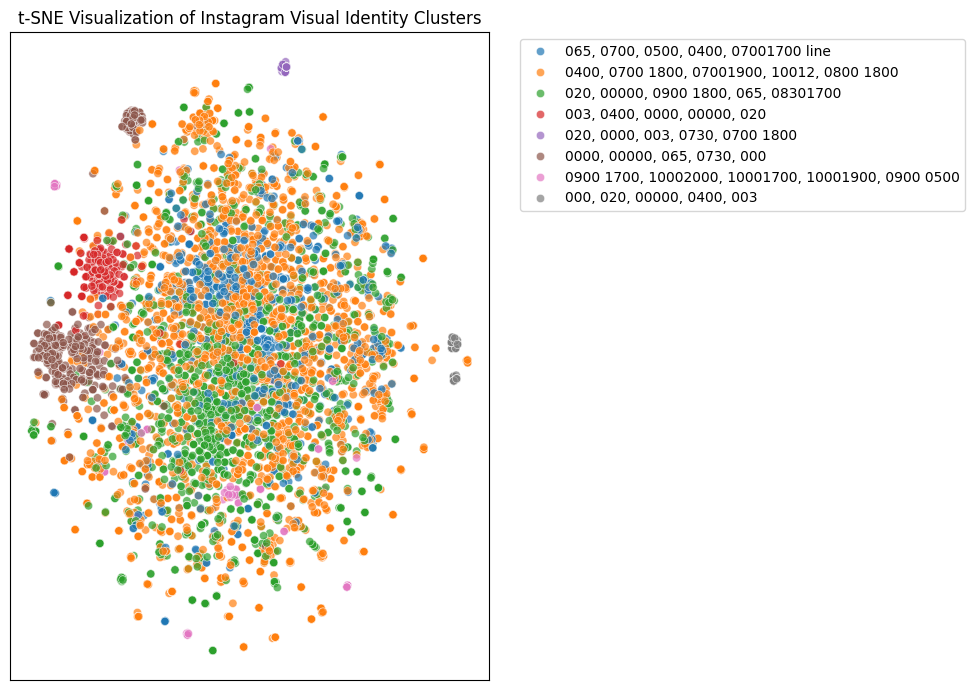

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import re
import nltk
from nltk.corpus import stopwords

# === CONFIG ===
CSV_PATH = "/Users/chivo/Downloads/data_studio/coffee/ig_ocr_with_clusters.csv"

# === Setup ===
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|@\S+|#\S+", "", str(text))
    text = re.sub(r"[^\w\s]", "", text.lower())
    return " ".join([w for w in text.split() if w not in stop_words and len(w) > 2])

# === Load and prepare data ===
df = pd.read_csv(CSV_PATH)
df["cleaned_text"] = df["ocr_text"].fillna("").apply(clean_text)

# === Vectorize ===
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 2))
X = vectorizer.fit_transform(df["cleaned_text"])

# === t-SNE for dimensionality reduction ===
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_embedded = tsne.fit_transform(X.toarray())

df["x"] = X_embedded[:, 0]
df["y"] = X_embedded[:, 1]

# === Plot ===
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="x", y="y",
    hue="cluster_label",
    palette="tab10",
    data=df,
    legend="full",
    alpha=0.7
)
plt.title("t-SNE Visualization of Instagram Visual Identity Clusters")
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.legend(loc="best", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


I tried clustering but the clusters made no sense, chatgpt and TfidfVectorizer clustered them into 0: "Branded Minimalism",
    1: "Chiang Mai Touristy",
    2: "Third Wave Aesthete",
    3: "Error Page or Low Text",
    4: "Local Roasters & Beans",
    5: "Community Focused",
    6: "Generic Coffee Phrases",
    7: "Design-Heavy Concept Café" but when i checked, they might not be the case, so now i'm pivoting to extract 'lifestyle' keywords instead like dog friendly, having a website or no, easy to contact? etc. 

Selects a random sample of ~500 rows, making sure every city is represented at least once

In [27]:
import pandas as pd
import random
import os
from dotenv import load_dotenv
from pathlib import Path
import openai

# === Load API key from .env ===
load_dotenv()
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# === Load CSVs ===
ocr_path = Path("/Users/chivo/Downloads/data_studio/coffee/ig_ocr_text_output.csv")
meta_path = Path("/Users/chivo/Downloads/data_studio/coffee/all_thirdwave_places.csv")

ocr_df = pd.read_csv(ocr_path)
meta_df = pd.read_csv(meta_path)

# === Clean names for matching ===
def clean(text):
    return str(text).replace(".png", "").replace("_", " ").strip().lower()

ocr_df["cafe_key"] = ocr_df["filename"].apply(clean)
meta_df["cafe_key"] = meta_df["place_name"].apply(lambda x: clean(x))

# === Merge on cleaned key ===
merged_df = pd.merge(ocr_df, meta_df[["cafe_key", "city"]], on="cafe_key", how="left")
merged_df = merged_df.dropna(subset=["city", "ocr_text"])
merged_df["ocr_text"] = merged_df["ocr_text"].astype(str)

# === Stratified sample of 500 bios across cities ===
def stratified_sample(df, group_col="city", total_sample_size=500):
    grouped = df.groupby(group_col)
    sample_per_group = max(1, total_sample_size // grouped.ngroups)
    samples = grouped.apply(lambda g: g.sample(n=min(sample_per_group, len(g)), random_state=42))
    return samples.reset_index(drop=True).sample(n=min(total_sample_size, len(samples)), random_state=42)

sampled_df = stratified_sample(merged_df, "city", total_sample_size=500)

# === Prepare GPT prompt in chunks ===
bios = sampled_df["ocr_text"].tolist()
bios = [b[:600] for b in bios]  # truncate long bios

# Split into chunks (e.g., 250 bios per batch)
batches = [bios[i:i+250] for i in range(0, len(bios), 250)]

def build_prompt(bios_subset):
    bios_text = "\n\n".join([f"{i+1}. {b}" for i, b in enumerate(bios_subset)])
    return f"""
You are analyzing Instagram bios and profile text from global third-wave coffee shops.

From the following examples, extract recurring *themes or lifestyle attributes*.

Examples: pet-friendly, design-forward, website-included, local desserts, vegan, origin focus, etc.

For each theme, provide:
- A short theme label
- A 1–2 sentence explanation
- 2–3 example phrases that illustrate it

Here are the bios:
{bios_text}
"""

# === Run GPT-4o across batches ===
results = []
for i, batch in enumerate(batches):
    print(f"🧠 Processing batch {i+1}/{len(batches)}...")

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are an expert in analyzing social media bios for lifestyle and branding signals."},
            {"role": "user", "content": build_prompt(batch)}
        ],
        temperature=0.5,
        max_tokens=3000
    )

    results.append(response.choices[0].message.content)

# === Save to file ===
output_text = "\n\n=== Batch Separator ===\n\n".join(results)
output_path = Path("/Users/chivo/Downloads/data_studio/coffee/instagram_bio_themes_full_gpt.txt")
with open(output_path, "w") as f:
    f.write(output_text)

print(f"\n✅ Done! Saved GPT output to: {output_path}")


/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_16951/212548730.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples = grouped.apply(lambda g: g.sample(n=min(sample_per_group, len(g)), random_state=42))


🧠 Processing batch 1/1...

✅ Done! Saved GPT output to: /Users/chivo/Downloads/data_studio/coffee/instagram_bio_themes_full_gpt.txt


After checking the instagram pages I think there are a few themes that can be added: 
Pet-Friendly

Signals openness, comfort, and outdoor seating.

Keywords: "dog friendly", "pets welcome", "🐶"

Design/Minimalist Aesthetic

Visual branding; often tied to interior photography.

Keywords: "aesthetic", "interior", "minimal", "vibes"

Vegan / Plant-Based

Strong lifestyle/culture signal for urban clientele.

Keywords: "vegan", "plant-based", "dairy-free", "alt milk"

Origin-Conscious / Ethical Coffee

Part of the third-wave ethos.

Keywords: "single origin", "direct trade", "fair trade", "traceable"

Concept / Hybrid Spaces

Coffee + retail, bookstore, florist, gallery, or bike shop.

Keywords: "concept store", "studio", "gallery", "multi-use"

Sustainability / Eco Values

Often mentioned in mission-driven brands.

Keywords: "sustainable", "eco-friendly", "zero waste"

Optional
Tourist-Oriented / English-Heavy

Especially in Chiang Mai, Bali, Istanbul etc.

Long bios in English + location tags could indicate tourist appeal

Quote / Vibes-Centric

Bios that are purely about a feeling or mood ("breathe & sip", “coffee is a hug”).

In [50]:
import pandas as pd
import re
from pathlib import Path

# === INPUT / OUTPUT PATH ===
INPUT_CSV = Path("/Users/chivo/Downloads/data_studio/coffee/coffee_shops_scraped_output1.csv")
OUTPUT_CSV = Path("/Users/chivo/Downloads/data_studio/coffee/website_ocr_with_themes.csv")

# === Load CSV ===
df = pd.read_csv(INPUT_CSV)
df["visible_text_all"] = df["visible_text_all"].fillna("").astype(str)

# === Define theme tag rules ===
theme_patterns = {
    "pet_friendly": r"\b(pet|dog|cat).*(friendly|welcome|allowed|lover|🐶|🐱|🐕|🐾)",
    "vegan_friendly": r"\b(vegan|plant[- ]?based|dairy[- ]?free)\b",
    "homemade_bakes": r"\b(home[- ]?made|house[- ]?made|baked|cakes|pastry|tart|dessert)\b",
    "design_minimal": r"\b(minimal|aesthetic|design|interior|concept|cozy|space|clean lines)\b",
    "origin_focus": r"\b(origin|ethiopia|colombia|kenya|direct trade|farm to cup|micro lot)\b",
    "community_events": r"\b(community|live music|expo|event|market|gathering|talk)\b",
    "ethical_sourcing": r"\b(sustainable|fair[- ]?trade|eco|ethical|organic)\b",
    "multi_location": r"\b(we're in|locations|multiple|branches|find us at|franchise|cities)\b",
    "local_identity": r"\b([@#]?(chiangmai|bangkok|tokyo|nyc|la|lisbon|berlin|london|melbourne))\b",
    "no_website": r"\b(no website|linktr\.ee|bio only|instagram only|not available online)\b",
}

# === Tagging function ===
def assign_themes(text):
    text = text.lower()
    matched = [theme for theme, pattern in theme_patterns.items() if re.search(pattern, text)]
    return ", ".join(matched) if matched else None

# === Apply tagging ===
df["themes"] = df["visible_text_all"].apply(assign_themes)

# === Save output ===
df.to_csv(OUTPUT_CSV, index=False)
print(f"✅ Saved to {OUTPUT_CSV} with new 'themes' column.")


✅ Saved to /Users/chivo/Downloads/data_studio/coffee/website_ocr_with_themes.csv with new 'themes' column.


define the themes and extract the keywords from the bios 

In [28]:
import pandas as pd
import re
from pathlib import Path

# === INPUT / OUTPUT PATH ===
INPUT_CSV = Path("/Users/chivo/Downloads/data_studio/coffee/ig_ocr_text_output.csv")
OUTPUT_CSV = Path("/Users/chivo/Downloads/data_studio/coffee/ig_ocr_with_themes.csv")

# === Load CSV ===
df = pd.read_csv(INPUT_CSV)
df["ocr_text"] = df["ocr_text"].fillna("").astype(str)

# === Define theme tag rules ===
theme_patterns = {
    "pet_friendly": r"\b(pet|dog|cat).*(friendly|welcome|allowed|lover|🐶|🐱|🐕|🐾)",
    "vegan_friendly": r"\b(vegan|plant[- ]?based|dairy[- ]?free)\b",
    "homemade_bakes": r"\b(home[- ]?made|house[- ]?made|baked|cakes|pastry|tart|dessert)\b",
    "design_minimal": r"\b(minimal|aesthetic|design|interior|concept|cozy|space|clean lines)\b",
    "origin_focus": r"\b(origin|ethiopia|colombia|kenya|direct trade|farm to cup|micro lot)\b",
    "community_events": r"\b(community|live music|expo|event|market|gathering|talk)\b",
    "ethical_sourcing": r"\b(sustainable|fair[- ]?trade|eco|ethical|organic)\b",
    "multi_location": r"\b(we're in|locations|multiple|branches|find us at|franchise|cities)\b",
    "local_identity": r"\b([@#]?(chiangmai|bangkok|tokyo|nyc|la|lisbon|berlin|london|melbourne))\b",
    "no_website": r"\b(no website|linktr\.ee|bio only|instagram only|not available online)\b",
}

# === Tagging function ===
def assign_themes(text):
    text = text.lower()
    matched = [theme for theme, pattern in theme_patterns.items() if re.search(pattern, text)]
    return ", ".join(matched) if matched else None

# === Apply tagging ===
df["themes"] = df["ocr_text"].apply(assign_themes)

# === Save output ===
df.to_csv(OUTPUT_CSV, index=False)
print(f"✅ Saved to {OUTPUT_CSV} with new 'themes' column.")


✅ Saved to /Users/chivo/Downloads/data_studio/coffee/ig_ocr_with_themes.csv with new 'themes' column.


chart chart chart 

/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_16951/1946826196.py:52: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


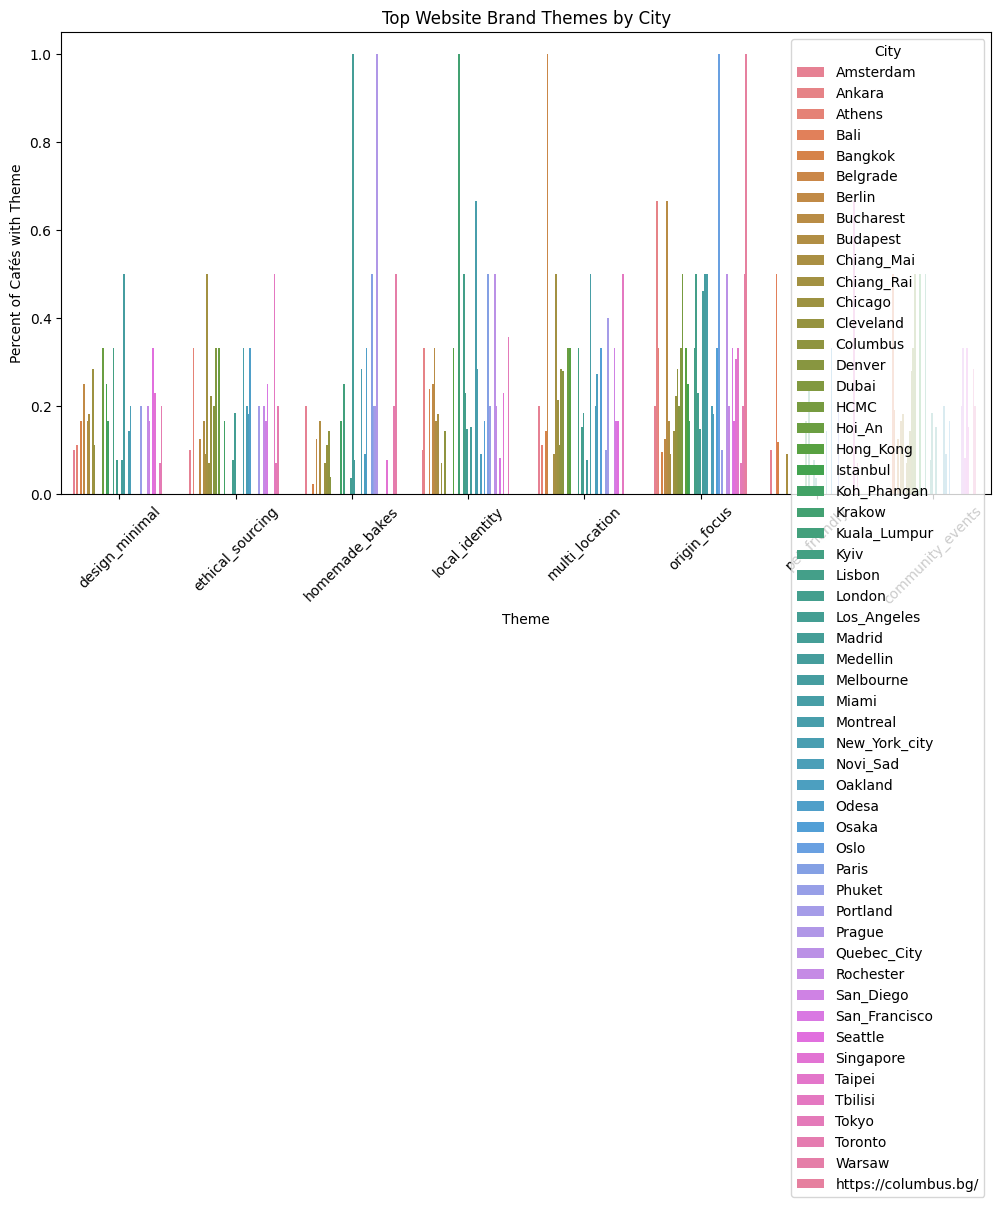

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
df = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/website_ocr_with_themes.csv")

# Drop rows with missing themes
df = df.dropna(subset=["themes"])

# Standardize theme format
df["themes"] = df["themes"].astype(str).str.lower().str.strip()

# Split multiple themes into separate rows
df["themes"] = df["themes"].str.split(",")
df_exploded = df.explode("themes")
df_exploded["themes"] = df_exploded["themes"].str.strip()

# Group and count theme occurrences by city
theme_counts = (
    df_exploded.groupby(["city", "themes"])
    .size()
    .reset_index(name="count")
)

# Normalize to get % of shops per city with each theme
theme_totals = theme_counts.groupby("city")["count"].transform("sum")
theme_counts["percent"] = theme_counts["count"] / theme_totals

# Keep top N themes overall
top_themes = (
    theme_counts.groupby("themes")["count"].sum()
    .sort_values(ascending=False)
    .head(8)
    .index.tolist()
)
df_top = theme_counts[theme_counts["themes"].isin(top_themes)]

# Plot: Stacked bar chart
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_top,
    x="themes",
    y="percent",
    hue="city"
)
plt.title("Top Website Brand Themes by City")
plt.xlabel("Theme")
plt.ylabel("Percent of Cafés with Theme")
plt.xticks(rotation=45)
plt.legend(title="City")
plt.tight_layout()
plt.show()


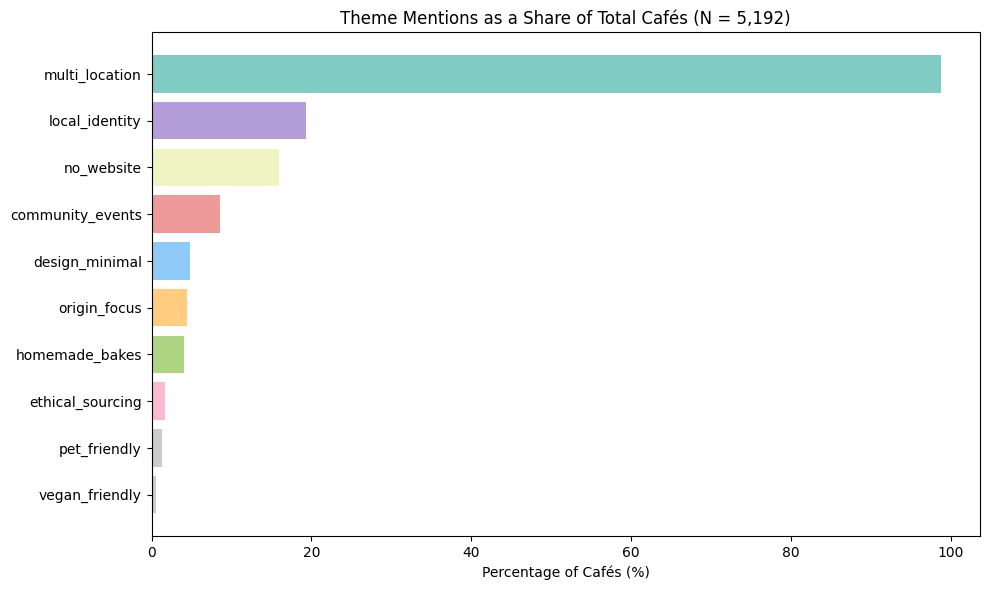

In [4]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv("ig_ocr_with_themes.csv")

# Total number of cafés (denominator for percentage)
total_cafes = 5192

# Count how many times each theme appears
theme_counts = Counter()
for themes in df["themes"].dropna():
    for theme in [t.strip() for t in themes.split(",")]:
        theme_counts[theme] += 1

# Convert to DataFrame and calculate percentage
theme_df = pd.DataFrame(theme_counts.items(), columns=["Theme", "Count"])
theme_df["Percent"] = (theme_df["Count"] / total_cafes) * 100
theme_df = theme_df.sort_values(by="Percent", ascending=True)

# Define custom color palette
theme_colors = {
    "multi_location": "#80cbc4",
    "no_website": "#f0f4c3",
    "local_identity": "#b39ddb",
    "community_events": "#ef9a9a",
    "design_minimal": "#90caf9",
    "origin_focus": "#ffcc80",
    "homemade_bakes": "#aed581",
    "ethical_sourcing": "#f8bbd0"
}

# Plot horizontal bar chart by percentage
plt.figure(figsize=(10, 6))
plt.barh(theme_df["Theme"], theme_df["Percent"], color=[theme_colors.get(t, "#cccccc") for t in theme_df["Theme"]])
plt.xlabel("Percentage of Cafés (%)")
plt.title("Theme Mentions as a Share of Total Cafés (N = 5,192)")
plt.tight_layout()
plt.savefig("theme_percent_horizontal_colored_instagram.svg", format="svg")
plt.show()


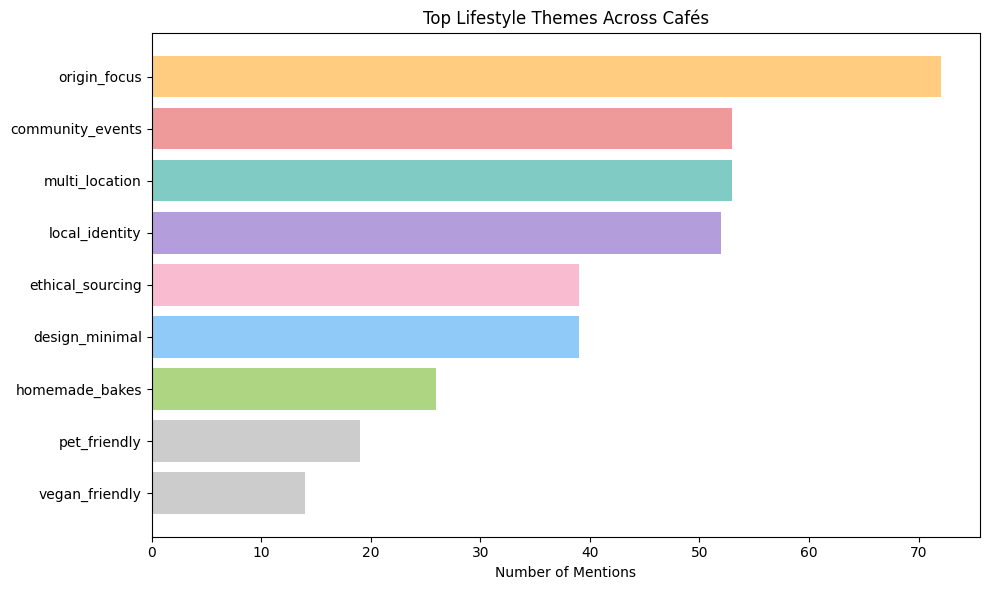

In [3]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Load website theme data
df = pd.read_csv("website_ocr_with_themes.csv")

# Total cafés for website set
total_cafes = 177

# Count themes
theme_counts = Counter()
for themes in df["themes"].dropna():
    for theme in [t.strip() for t in themes.split(",")]:
        theme_counts[theme] += 1

# Convert to DataFrame and compute percent
theme_df = pd.DataFrame(theme_counts.items(), columns=["Theme", "Count"])
theme_df["Percent"] = (theme_df["Count"] / total_cafes) * 100
theme_df = theme_df.sort_values(by="Percent", ascending=True)

# Color palette
theme_colors = {
    "multi_location": "#80cbc4",
    "no_website": "#f0f4c3",
    "local_identity": "#b39ddb",
    "community_events": "#ef9a9a",
    "design_minimal": "#90caf9",
    "origin_focus": "#ffcc80",
    "homemade_bakes": "#aed581",
    "ethical_sourcing": "#f8bbd0"
}

# Plot
plt.figure(figsize=(10, 6))
plt.barh(theme_df["Theme"], theme_df["Percent"], color=[theme_colors.get(t, "#cccccc") for t in theme_df["Theme"]])
plt.xlabel("Percentage of Cafés (%)")
plt.title("Theme Mentions on Café Websites (N = 177)")
plt.tight_layout()
plt.savefig("theme_percent_horizontal_colored_website.svg", format="svg")
plt.show()


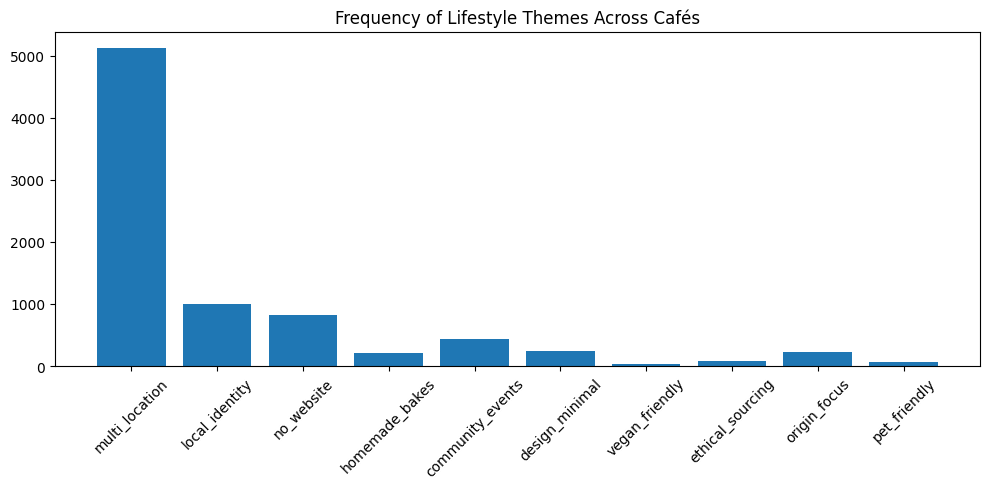

In [29]:
from collections import Counter
import matplotlib.pyplot as plt

theme_counts = Counter()

for themes in df["themes"].dropna():
    for theme in [t.strip() for t in themes.split(",")]:
        theme_counts[theme] += 1

# Plot
plt.figure(figsize=(10, 5))
plt.bar(theme_counts.keys(), theme_counts.values())
plt.xticks(rotation=45)
plt.title("Frequency of Lifestyle Themes Across Cafés")
plt.tight_layout()
plt.savefig("/Users/chivo/Downloads/data_studio/coffee/theme_counts_instagram.svg")
plt.show()


In [20]:
# !pip install openai==0.28
# !pip install openai python-dotenv
!pip show openai



Name: openai
Version: 0.28.0
Summary: Python client library for the OpenAI API
Home-page: https://github.com/openai/openai-python
Author: OpenAI
Author-email: support@openai.com
License: 
Location: /Users/chivo/.pyenv/versions/3.10.12/lib/python3.10/site-packages
Requires: aiohttp, requests, tqdm
Required-by: vllm


Now!!! detect the instgram pages and see the visual identities running through chatgpt4-vision 

In [6]:
# !pip install openai pandas tqdm pillow


In [7]:
import openai
from dotenv import load_dotenv
import os

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")


In [25]:
import pandas as pd
import os
import re
import random
from collections import defaultdict

# === CONFIG ===
SCREENSHOT_DIR = "/Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe"
CITY_CSV = "/Users/chivo/Downloads/data_studio/coffee/all_thirdwave_places.csv"
OUTPUT_CSV = "/Users/chivo/Downloads/data_studio/coffee/ig_sample_500.csv"
MAX_TOTAL = 500
MAX_PER_CITY = 5

# Load city data
city_df = pd.read_csv(CITY_CSV)
city_df = city_df.dropna(subset=["city"])
city_df["city_clean"] = city_df["city"].apply(lambda x: re.sub(r"[^\w\s-]", "", str(x)).strip().replace(" ", "_").lower())
unique_cities = set(city_df["city_clean"].unique())

# Scan screenshot directory
city_files = defaultdict(list)
for fname in os.listdir(SCREENSHOT_DIR):
    if fname.endswith(".png"):
        lower_fname = fname.lower()
        for city in unique_cities:
            if city in lower_fname:
                city_files[city].append(os.path.join(SCREENSHOT_DIR, fname))
                break

# Randomly sample files
final_files = []
for city, files in city_files.items():
    sample = random.sample(files, min(MAX_PER_CITY, len(files)))
    final_files.extend(sample)

# Limit to MAX_TOTAL
if len(final_files) > MAX_TOTAL:
    final_files = random.sample(final_files, MAX_TOTAL)

# Save result
df = pd.DataFrame({"image_path": final_files})
df.to_csv(OUTPUT_CSV, index=False)

print(f"✅ Saved {len(final_files)} sample paths to:\n{OUTPUT_CSV}")


✅ Saved 478 sample paths to:
/Users/chivo/Downloads/data_studio/coffee/ig_sample_500.csv


In [31]:
# !pip install openai python-dotenv tqdm pandas


In [32]:
import os
import base64
import openai
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from dotenv import load_dotenv
import json

# Load OpenAI key
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

# === CONFIG ===
IMAGE_DIR = "/Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe"
INPUT_CSV = "/Users/chivo/Downloads/data_studio/coffee/ig_sample_500.csv"
OUTPUT_JSONL = "/Users/chivo/Downloads/data_studio/coffee/ig_sample_500_labeled.jsonl"

# === PROMPT ===
PROMPT = """
You are a visual content analyst. This is a screenshot of an Instagram profile from a coffee shop. Your task is to identify and name the most prominent visual traits and thematic patterns in the image — especially those that suggest how the coffee shop wants to present its brand, atmosphere, or lifestyle.

Please look for:
- Recurring composition or camera angles (e.g. consistent bar-view POV, symmetry, top-down food shots)
- Aesthetic decisions (e.g. minimalism, vintage tones, natural wood textures, warm vs. cool lighting)
- Environmental cues (e.g. plants, signage, seating, tableware)
- Emphasis on human activity vs. product showcase
- Framing style (e.g. wide interior vs. object close-up)
- Any branding consistency (e.g. similar color palette, props)

Avoid generic object tags (e.g. “coffee” or “café interior”) — focus on the *style*, *tone*, and *presentation*.

If multiple images share the same composition or atmosphere (e.g. every photo framed behind a wooden bench), highlight this as a key stylistic choice.

Return a list of ~10–12 short labels or themes (max 5 words each), capturing the most dominant visual characteristics.

Also include a short comment if you notice any **intentional stylistic repetition**, such as:
> “All photos seem shot from across a wooden bar, as if inviting the viewer to sit.”

Output format (in JSON):
{
  "themes": [
    "wooden bar framing",
    "plant-forward aesthetic",
    "close-up product shots"
  ],
  "comment": "Photos are consistently shot from a low angle behind a wood bench to simulate a customer's view."
}
"""

# === Run classification ===
def encode_image(path):
    with open(path, "rb") as img:
        return base64.b64encode(img.read()).decode("utf-8")

df = pd.read_csv(INPUT_CSV)
results = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = row["image_path"]
    if not Path(img_path).exists():
        continue

    image_b64 = encode_image(img_path)

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4-vision-preview",
            messages=[
                {"role": "user", "content": [
                    {"type": "text", "text": PROMPT},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{image_b64}"}}
                ]}
            ],
            max_tokens=800
        )

        analysis = response["choices"][0]["message"]["content"]
        results.append({"image_path": img_path, "analysis": analysis})

    except Exception as e:
        results.append({"image_path": img_path, "analysis": f"[ERROR] {str(e)}"})

# Save as .jsonl
with open(OUTPUT_JSONL, "w") as f:
    for r in results:
        f.write(json.dumps(r) + "\n")

print(f"✅ Done! Saved to: {OUTPUT_JSONL}")


100%|██████████| 478/478 [00:01<00:00, 261.91it/s]

✅ Done! Saved to: /Users/chivo/Downloads/data_studio/coffee/ig_sample_500_labeled.jsonl


In [34]:
# !pip install openai


trying with 10 images first. Amazing, 10 was a success, lets try 500 now. 

In [38]:
import os
import base64
import pandas as pd
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# === Config ===
CSV_PATH = "/Users/chivo/Downloads/data_studio/coffee/ig_sample_500.csv"
OUTPUT_PATH = "/Users/chivo/Downloads/data_studio/coffee/ig_sample_500_labeled.jsonl"
NUM_IMAGES = 500

# === Prompt ===
prompt = """
You are a visual content analyst. This is a screenshot of an Instagram profile from a coffee shop. Your task is to identify and name the most prominent visual traits and thematic patterns in the image — especially those that suggest how the coffee shop wants to present its brand, atmosphere, or lifestyle.

Please look for:
- Recurring composition or camera angles (e.g. consistent bar-view POV, symmetry, top-down food shots)
- Aesthetic decisions (e.g. minimalism, vintage tones, natural wood textures, warm vs. cool lighting)
- Environmental cues (e.g. plants, signage, seating, tableware)
- Emphasis on human activity vs. product showcase
- Framing style (e.g. wide interior vs. object close-up)
- Any branding consistency (e.g. similar color palette, props)

Avoid generic object tags (e.g. “coffee” or “café interior”) — focus on the *style*, *tone*, and *presentation*.

If multiple images share the same composition or atmosphere (e.g. every photo framed behind a wooden bench), highlight this as a key stylistic choice.

Return a list of ~10–12 short labels or themes (max 5 words each), capturing the most dominant visual characteristics.

Also include a short comment if you notice any **intentional stylistic repetition**, such as:
> “All photos seem shot from across a wooden bar, as if inviting the viewer to sit.”

Output format (in JSON):
{
  "themes": [...],
  "comment": "..."
}
"""

# === Load file list
df = pd.read_csv(CSV_PATH)
sample_paths = df["image_path"].tolist()[:NUM_IMAGES]

with open(OUTPUT_PATH, "w") as out:
    for i, path in enumerate(sample_paths):
        print(f"{i+1}/{NUM_IMAGES} 📸 {path}")
        try:
            with open(path, "rb") as f:
                b64 = base64.b64encode(f.read()).decode("utf-8")

            response = client.chat.completions.create(
                model="gpt-4-turbo",  # ✅ the correct model now
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": prompt},
                            {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{b64}"}}
                        ]
                    }
                ],
                max_tokens=800
            )

            content = response.choices[0].message.content.strip().replace("\n", "")
            out.write(f'{{"image_path": "{path}", "analysis": {content}}}\n')

        except Exception as e:
            print(f"❌ Failed on {path}: {e}")
            out.write(f'{{"image_path": "{path}", "analysis": "[ERROR: {str(e)}]"}}\n')

print(f"\n✅ Saved all results to {OUTPUT_PATH}")


1/500 📸 /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/BEAN_BROTHERS_PJ_Kuala_Lumpur.png
2/500 📸 /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Beam_Specialty_Sdn_Bhd_Kuala_Lumpur.png
3/500 📸 /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/FEEKA_by_the_Park_Kuala_Lumpur.png
4/500 📸 /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Brewmen_Coffee_Kuala_Lumpur.png
5/500 📸 /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/103_Coffee_Workshop_C180_Branch_Kuala_Lumpur.png
6/500 📸 /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Gold_Star_Coffee_Da_Nang.png
7/500 📸 /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Dngcoffee_Da_Nang.png
8/500 📸 /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/The_Hideout_café_Da_Nang.png
9/500 📸 /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Why_Coffee_Roastery_Da_Nang.png
10/500 📸 /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vi

KeyboardInterrupt: 

so after a few photos, i ran out of money $3.00 so now i need to change my strategy:________ 
 3/500 📸 /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Sam_James_Coffee_Bar_TORONTO_ST_SHOP_Toronto.png
84/500 📸 /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Mofer_Coffee_Danforth_Toronto.png
85/500 📸 /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Fix_Coffee__Bikes_Toronto.png
86/500 📸 /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Battery_Park_Book_Exchange_Asheville.png
❌ Failed on /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Battery_Park_Book_Exchange_Asheville.png: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
87/500 📸 /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/PennyCup_Coffee_Haw_Creek_Asheville.png
❌ Failed on /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/PennyCup_Coffee_Haw_Creek_Asheville.png: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
88/500 📸 /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Liberty_House_Coffee_and_Café_Asheville.png
❌ Failed on /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Liberty_House_Coffee_and_Café_Asheville.png: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
89/500 📸 /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Moments_Coffee_Bar__Eatery_Asheville.png
❌ Failed on /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Moments_Coffee_Bar__Eatery_Asheville.png: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
90/500 📸 /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Counter_Culture_Coffee_Asheville_Trainin_Asheville.png
❌ Failed on /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Counter_Culture_Coffee_Asheville_Trainin_Asheville.png: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
91/500 📸 /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Espressolab_Boğaziçi_Istanbul.png
❌ Failed on /Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe/Espressolab_Boğaziçi_Istanbul.png: Error code: 429 

In [39]:
!pip install playwright browser-cookie3
!playwright install



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [40]:
import browser_cookie3
import json

cookies = browser_cookie3.chrome(domain_name="chat.openai.com")

with open("chatgpt_cookies.json", "w") as f:
    json.dump([
        {
            "name": c.name,
            "value": c.value,
            "domain": c.domain,
            "path": c.path,
            "httpOnly": c._rest.get("HttpOnly", False),
            "secure": c.secure,
            "sameSite": "Lax"
        } for c in cookies
    ], f, indent=2)

print("✅ Cookies saved to chatgpt_cookies.json")


✅ Cookies saved to chatgpt_cookies.json


In [43]:
import json
import nest_asyncio
import asyncio
from playwright.async_api import async_playwright

nest_asyncio.apply()

async def run():
    async with async_playwright() as p:
        # ✅ Launch browser
        browser = await p.chromium.launch(headless=False)
        context = await browser.new_context()

        # ✅ Load cookies from file
        with open("chatgpt_cookies.json", "r") as f:
            cookies = json.load(f)
        await context.add_cookies(cookies)

        # ✅ Visit ChatGPT (should be logged in)
        page = await context.new_page()
        await page.goto("https://chat.openai.com/chat")
        await page.wait_for_timeout(5000)

        print("✅ Page loaded with cookies")

        await browser.close()

await run()


✅ Page loaded with cookies


150 minutes trying and ran out of money with chatgpt-vision model :((

In [49]:
import os
import base64
import pandas as pd
import json
from tqdm.contrib.concurrent import thread_map
from openai import OpenAI
from dotenv import load_dotenv

# === Load API Key ===
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# === CONFIG ===
FOLDER_PATH = "/Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe"
OUTPUT_CSV = "/Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe_labeled.csv"
INTERIM_SAVE_EVERY = 25

# === Prompt Template ===
PROMPT = """
You are a visual content analyst. This is a screenshot of an Instagram profile from a coffee shop. Your task is to identify and name the most prominent visual traits and thematic patterns in the image — especially those that suggest how the coffee shop wants to present its brand, atmosphere, or lifestyle.

Please look for:
- Recurring composition or camera angles (e.g. consistent bar-view POV, symmetry, top-down food shots)
- Aesthetic decisions (e.g. minimalism, vintage tones, natural wood textures, warm vs. cool lighting)
- Environmental cues (e.g. plants, signage, seating, tableware)
- Emphasis on human activity vs. product showcase
- Framing style (e.g. wide interior vs. object close-up)
- Any branding consistency (e.g. similar color palette, props)

Avoid generic object tags (e.g. “coffee” or “café interior”) — focus on the *style*, *tone*, and *presentation*.

If multiple images share the same composition or atmosphere (e.g. every photo framed behind a wooden bench), highlight this as a key stylistic choice.

Return a list of ~10–12 short labels or themes (max 5 words each), capturing the most dominant visual characteristics.

Also include a short comment if you notice any **intentional stylistic repetition**, such as:
> “All photos seem shot from across a wooden bar, as if inviting the viewer to sit.”

Output format (in JSON):
{
  "themes": [...],
  "comment": "..."
}
"""

# === Get image list
image_paths = sorted([
    os.path.join(FOLDER_PATH, f) for f in os.listdir(FOLDER_PATH)
    if f.endswith(".png")
])

# === Resume if file exists
if os.path.exists(OUTPUT_CSV):
    existing = pd.read_csv(OUTPUT_CSV)
    processed = set(existing["image_path"])
else:
    existing = pd.DataFrame(columns=["image_path", "themes", "comment"])
    processed = set()

# === GPT call
def analyze_image(path):
    if path in processed:
        return None
    try:
        with open(path, "rb") as f:
            b64 = base64.b64encode(f.read()).decode("utf-8")

        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "user", "content": [
                    {"type": "text", "text": PROMPT},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{b64}"}}
                ]}
            ],
            max_tokens=800
        )

        content = json.loads(response.choices[0].message.content)
        return {"image_path": path, "themes": "; ".join(content["themes"]), "comment": content["comment"]}

    except Exception as e:
        return {"image_path": path, "themes": "[ERROR]", "comment": str(e)}

# === Batch process
def run():
    to_process = [p for p in image_paths if p not in processed]
    interim = []
    count = 0

    for result in thread_map(analyze_image, to_process, max_workers=4, chunksize=1, desc="Analyzing"):
        if result:
            interim.append(result)
            count += 1

        if count % INTERIM_SAVE_EVERY == 0 and interim:
            new_df = pd.DataFrame(interim)
            combined = pd.concat([existing, new_df]).drop_duplicates("image_path")
            combined.to_csv(OUTPUT_CSV, index=False)
            interim.clear()
            print(f"💾 Interim save at {count}...")

    if interim:
        final_df = pd.concat([existing, pd.DataFrame(interim)]).drop_duplicates("image_path")
        final_df.to_csv(OUTPUT_CSV, index=False)
        print("✅ Final batch saved!")

run()


Analyzing:   0%|          | 0/5191 [00:00<?, ?it/s]

💾 Interim save at 25...
💾 Interim save at 50...
💾 Interim save at 75...
💾 Interim save at 100...
💾 Interim save at 125...
💾 Interim save at 150...
💾 Interim save at 175...
💾 Interim save at 200...
💾 Interim save at 225...
💾 Interim save at 250...
💾 Interim save at 275...
💾 Interim save at 300...
💾 Interim save at 325...
💾 Interim save at 350...
💾 Interim save at 375...
💾 Interim save at 400...
💾 Interim save at 425...
💾 Interim save at 450...
💾 Interim save at 475...
💾 Interim save at 500...
💾 Interim save at 525...
💾 Interim save at 550...
💾 Interim save at 575...
💾 Interim save at 600...
💾 Interim save at 625...
💾 Interim save at 650...
💾 Interim save at 675...
💾 Interim save at 700...
💾 Interim save at 725...
💾 Interim save at 750...
💾 Interim save at 775...
💾 Interim save at 800...
💾 Interim save at 825...
💾 Interim save at 850...
💾 Interim save at 875...
💾 Interim save at 900...
💾 Interim save at 925...
💾 Interim save at 950...
💾 Interim save at 975...
💾 Interim save at 1000...
💾 

In [46]:
import asyncio
from pathlib import Path
from playwright.async_api import async_playwright
import json
import random
import time

# === CONFIG ===
IMAGE_DIR = Path("/Users/chivo/Downloads/data_studio/coffee/ig_screenshots_vibe")
OUTPUT_PATH = Path("/Users/chivo/Downloads/data_studio/coffee/chatgpt_vision_results.jsonl")
BATCH_SIZE = 10  # You can change this based on memory
WAIT_TIME = 25   # Time for GPT-4 Vision to process + render reply

# === Prompt ===
prompt = """
You are a visual content analyst. This is a screenshot of an Instagram profile from a coffee shop. Your task is to identify and name the most prominent visual traits and thematic patterns in the image — especially those that suggest how the coffee shop wants to present its brand, atmosphere, or lifestyle.

Please look for:
- Recurring composition or camera angles (e.g. consistent bar-view POV, symmetry, top-down food shots)
- Aesthetic decisions (e.g. minimalism, vintage tones, natural wood textures, warm vs. cool lighting)
- Environmental cues (e.g. plants, signage, seating, tableware)
- Emphasis on human activity vs. product showcase
- Framing style (e.g. wide interior vs. object close-up)
- Any branding consistency (e.g. similar color palette, props)

Avoid generic object tags (e.g. “coffee” or “café interior”) — focus on the *style*, *tone*, and *presentation*.

If multiple images share the same composition or atmosphere (e.g. every photo framed behind a wooden bench), highlight this as a key stylistic choice.

Return a list of ~10–12 short labels or themes (max 5 words each), capturing the most dominant visual characteristics.

Also include a short comment if you notice any **intentional stylistic repetition**, such as:
> “All photos seem shot from across a wooden bar, as if inviting the viewer to sit.”

Output format (in JSON):
{
  "themes": [...],
  "comment": "..."
}
"""

# === Automation ===
async def run():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=False)
        context = await browser.new_context(storage_state="chatgpt_state.json")
        page = await context.new_page()
        await page.goto("https://chat.openai.com/")

        # Wait for user session
        await page.wait_for_selector("textarea")

        image_paths = list(IMAGE_DIR.glob("*.png"))
        random.shuffle(image_paths)
        image_paths = image_paths[:5000]  # Limit to 5000 max

        processed = 0
        for i in range(0, len(image_paths), BATCH_SIZE):
            batch = image_paths[i:i + BATCH_SIZE]
            print(f"\n🧠 Processing batch {i // BATCH_SIZE + 1}: {len(batch)} files")

            # Click reset/new chat
            await page.goto("https://chat.openai.com/")
            await page.wait_for_selector("textarea")

            # Send prompt
            await page.locator("textarea").fill(prompt)
            await page.keyboard.press("Enter")
            await asyncio.sleep(3)

            # Upload each file
            for img_path in batch:
                input_box = await page.query_selector("input[type='file']")
                await input_box.set_input_files(str(img_path))
                await asyncio.sleep(2)

            # Wait for GPT to reply
            await asyncio.sleep(WAIT_TIME)

            # Extract response
            messages = await page.query_selector_all("div[class*='markdown']")
            if messages:
                last = await messages[-1].inner_text()
                for img_path in batch:
                    with open(OUTPUT_PATH, "a") as f:
                        f.write(json.dumps({"image_path": str(img_path), "analysis": last}) + "\n")
            else:
                print(f"⚠️ No reply for batch {i // BATCH_SIZE + 1}")

            processed += len(batch)

        print(f"\n✅ Done! {processed} images analyzed.")

# === One-time login (optional)
# To be run once to save cookies
async def save_login():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=False)
        context = await browser.new_context()
        page = await context.new_page()
        await page.goto("https://chat.openai.com/")
        print("⚠️ Please log in manually, then press ENTER here.")
        input()
        await context.storage_state(path="chatgpt_state.json")
        print("✅ Login cookies saved.")

# === Entry Point ===
if __name__ == "__main__":
    # Run once to save session cookies
    # asyncio.run(save_login())

    # Run this to process all 5000 images using saved session
    asyncio.run(run())


/Users/chivo/.pyenv/versions/3.10.12/lib/python3.10/ast.py:50: RuntimeWarning: coroutine 'run' was never awaited
  return compile(source, filename, mode, flags,


FileNotFoundError: [Errno 2] No such file or directory: 'chatgpt_state.json'